In [49]:
import os
import sys
import pickle
import random
import shap
import numpy as np
import pandas as pd
sys.path.append('../src/')
from configs import *
from plotting import *
from clustering import *
from optimization import *
from tqdm.notebook import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
rcParams.update(fig_params)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset and model

In [8]:
feature_list = ['physicochemical',
                'AAC',
                'CKSAAP type 1',
                'TPC type 1',
                'DPC type 1',
                'DDE',
                'GAAC',
                'CKSAAGP type 1',
                'GDPC type 1',
                'GTPC type 1',
                'Moran',
                'Geary',
                'NMBroto',
                'CTDC',
                'CTDT',
                'CTDD',
                'CTriad',
                'KSCTriad',
                'SOCNumber',
                'QSOrder',
                'PAAC',
                'APAAC',
                'ASDC',
                'AC',
                'CC',
                'ACC',
                'EAAC',
                'EGAAC',
                'AAIndex',
                'BLOSUM62',
                'ZScale'
               ]

comb, features = load_dataset(feature_list=feature_list, dataset_name='comb', features_folder=os.path.join('..', 'features'))
## Train dataset
train = comb[comb.Dataset=='train'].copy()
test  = comb[comb.Dataset=='test'].copy()

In [9]:
## Featurizer
featurizer = Featurizer(data_folder=os.path.join('..', 'data'))

## Model
with open(os.path.join('..', 'models', 'LightCPP_20.pickle'), 'rb') as handle:
    models = pickle.load(handle)
best_iteration = models['best_iteration']
n_models = 1

## Selected features
selected_features = ['CTDC_charge.G1',
                     'CTDD_hydrophobicity_ARGP820101.1.residue50',
                     'CKSAAP_IR.gap2',
                     'CTDD_normwaalsvolume.2.residue100',
                     'DDE_LA',
                     'ASDC_AS',
                     'PAAC_Xc1.V',
                     'APAAC_Pc2.Hydrophobicity.1',
                     'DDE_LP',
                     'CKSAAP_LL.gap4',
                     'APAAC_Pc1.A',
                     'CTDD_hydrophobicity_FASG890101.2.residue50',
                     'CKSAAGP_postivecharger.uncharger.gap1',
                     'KSCTriad_g5.g5.g5.gap1',
                     'ZScale_p1.z5',
                     'QSOrder_Grantham.Xr.T',
                     'ASDC_DM',
                     'CKSAAP_TR.gap4',
                     'PAAC_Xc1.G',
                     'CKSAAGP_uncharger.aromatic.gap9']

In [10]:
train_selected = pd.DataFrame(train['Sequence'].apply(lambda x: featurizer.compute_features(x).values[0]).tolist(), index=train.index, columns=selected_features)
test_selected = pd.DataFrame(test['Sequence'].apply(lambda x: featurizer.compute_features(x).values[0]).tolist(), index=test.index, columns=selected_features)

In [12]:
assert(train[selected_features].equals(train_selected[selected_features]))
assert(test[selected_features].equals(test_selected[selected_features]))

## Load optimized sequences and compute features before and after

In [29]:
df1 = pd.read_csv('../data/PeptidesForShap.csv')
df2 = pd.read_csv('../data/PeptidesForShap2.csv')
df = pd.concat([df1, df2], ignore_index=True)

Original_nonCPP = pd.DataFrame(index=range(len(df)), columns=['ID', 'Sequence', 'CPP', 'Dataset'])
Original_nonCPP['ID'] = [f'Negative_{i}' for i in range(1, len(df)+1)]
Original_nonCPP['Sequence'] = df['Original'].values
Original_nonCPP['CPP'] = 0
Original_nonCPP['Dataset'] = 'Original_nonCPP'

Optimized = pd.DataFrame(index=range(len(df)), columns=['ID', 'Sequence', 'CPP', 'Dataset'])
Optimized['ID'] = [f'Positive_{i}' for i in range(1, len(df)+1)]
Optimized['Sequence'] = df['Optimized'].values
Optimized['CPP'] = 1
Optimized['Dataset'] = 'Optimized_CPP'

test_optimized = pd.concat([Original_nonCPP, Optimized], ignore_index=True)
test_optimized

ID                              Sequence  CPP          Dataset
0    Negative_1       GEGAHVKIVANLPYYITTPILMQLLRAKISW    0  Original_nonCPP
1    Negative_2                             GEPWKVCVN    0  Original_nonCPP
2    Negative_3    VISANIRTTISGMDDSGGTGSRQKFRKLRKIERE    0  Original_nonCPP
3    Negative_4                LDPIVAKRVRHILTENARTVEA    0  Original_nonCPP
4    Negative_5                     DAWRMHMQEFVAQLETR    0  Original_nonCPP
5    Negative_6                IFSNTALVNCMRQTLQDTGHNP    0  Original_nonCPP
6    Negative_7          ETGGEFGKGVIRAELDVKPDLWFFGCHF    0  Original_nonCPP
7    Negative_8              TIVARSIAVGLQEAVREMKRLVQN    0  Original_nonCPP
8    Negative_9                          PNILTGAIVGGP    0  Original_nonCPP
9   Negative_10                      TAVEQKYRFFSYGDAM    0  Original_nonCPP
10  Negative_11  YLYVDCSNIPSISLDPGFRSMSDQNQVQMLINTYKR    0  Original_nonCPP
11  Negative_12               SAVEKDREDFREAVVKTLDRLLF    0  Original_nonCPP
12  Negative_13                      QFLQVQNAVIKIQSSY    0  Original_nonCPP
13  Negative_14    ELATQIFEEARKFTYRSWVRPCVVYGGAPIGNQM    0  Original_nonCPP
14  Negative_15           ALAIIEESKQSGTPVSVGLLGNAADVY    0  Original_nonCPP
15   Positive_1       WEGAHAKIAARLPYYLTTPLLMQLLRAKMKW    1    Optimized_CPP
16   Positive_2                             GKPWKICVR    1    Optimized_CPP
17   Positive_3    CISANIRTTISGMDDSGGTGKRKKFRKLRKIKRK    1    Optimized_CPP
18   Positive_4                LDPIVKKRRRHILTENTRTVEA    1    Optimized_CPP
19   Positive_5                     KAWRMHMQKFVARLKTR    1    Optimized_CPP
20   Positive_6                IFKRTALINCRRRTLQDTGHNP    1    Optimized_CPP
21   Positive_7          WTGGKFGKGKIRGKLDIKPDLWFFGCHF    1    Optimized_CPP
22   Positive_8              TIVARSIAVGLQEAIRRRKRLVQN    1    Optimized_CPP
23   Positive_9                          PNILTRAILGGP    1    Optimized_CPP
24  Positive_10                      CAAKKKYRFFSYGDAM    1    Optimized_CPP
25  Positive_11  YLYIDCSNIPSISLDPGFRSKKKKNRIQRLINTYKR    1    Optimized_CPP
26  Positive_12               SKRRKDREDFREAIIKTLDRLLF    1    Optimized_CPP
27  Positive_13                      QFLQVKNAVIKIRSRY    1    Optimized_CPP
28  Positive_14    ELATKIFKRARKFRYRIWVRPCVVYGGAPIGNRM    1    Optimized_CPP
29  Positive_15           ALAIIEESKLKGRPLAIGLLGNAADAY    1    Optimized_CPP

In [30]:
test_optimized_features = pd.DataFrame(test_optimized['Sequence'].apply(lambda x: featurizer.compute_features(x).values[0]).tolist(), index=test_optimized.index, columns=selected_features)
test_optimized_features.head()

CTDC_charge.G1  CTDD_hydrophobicity_ARGP820101.1.residue50  CKSAAP_IR.gap2  \
0        0.096774                                   35.483871             0.0   
1        0.111111                                   11.111111             0.0   
2        0.235294                                   44.117647             0.0   
3        0.181818                                   68.181818             0.0   
4        0.117647                                   52.941176             0.0   

   CTDD_normwaalsvolume.2.residue100    DDE_LA   ASDC_AS  PAAC_Xc1.V  \
0                          93.548387 -0.441308  0.006452    1.809495   
1                         100.000000 -0.227890  0.000000    1.753935   
2                         100.000000 -0.462847  0.005348    0.897290   
3                          95.454545 -0.369225  0.000000    2.657518   
4                          88.235294 -0.322286  0.000000    0.880480   

   APAAC_Pc2.Hydrophobicity.1    DDE_LP  CKSAAP_LL.gap4  APAAC_Pc1.A  \
0                   -0.016257  1.839395             0.0     3.060164   
1                   -0.023393 -0.227890             0.0     0.000000   
2                   -0.000677 -0.462847             0.0     0.994991   
3                   -0.005284 -0.369225             0.0     3.025147   
4                   -0.017528 -0.322286             0.0     2.078100   

   CTDD_hydrophobicity_FASG890101.2.residue50  \
0                                   35.483871   
1                                   11.111111   
2                                   35.294118   
3                                   63.636364   
4                                   94.117647   

   CKSAAGP_postivecharger.uncharger.gap1  KSCTriad_g5.g5.g5.gap1  \
0                               0.034483                     0.0   
1                               0.142857                     0.0   
2                               0.031250                     0.5   
3                               0.000000                     0.0   
4                               0.066667                     0.0   

   ZScale_p1.z5  QSOrder_Grantham.Xr.T   ASDC_DM  CKSAAP_TR.gap4  PAAC_Xc1.G  \
0         -0.38               0.000059  0.000000             0.0    1.809495   
1         -0.38               0.000000  0.000000             0.0    0.876968   
2         -0.02               0.000084  0.000000             0.0    3.589160   
3          0.84               0.000084  0.000000             0.0    0.000000   
4          0.75               0.000049  0.014706             0.0    0.000000   

   CKSAAGP_uncharger.aromatic.gap9  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0

In [32]:
test_optimized = pd.concat([test_optimized, test_optimized_features], axis=1)
test_optimized.head()

ID                            Sequence  CPP          Dataset  \
0  Negative_1     GEGAHVKIVANLPYYITTPILMQLLRAKISW    0  Original_nonCPP   
1  Negative_2                           GEPWKVCVN    0  Original_nonCPP   
2  Negative_3  VISANIRTTISGMDDSGGTGSRQKFRKLRKIERE    0  Original_nonCPP   
3  Negative_4              LDPIVAKRVRHILTENARTVEA    0  Original_nonCPP   
4  Negative_5                   DAWRMHMQEFVAQLETR    0  Original_nonCPP   

   CTDC_charge.G1  CTDD_hydrophobicity_ARGP820101.1.residue50  CKSAAP_IR.gap2  \
0        0.096774                                   35.483871             0.0   
1        0.111111                                   11.111111             0.0   
2        0.235294                                   44.117647             0.0   
3        0.181818                                   68.181818             0.0   
4        0.117647                                   52.941176             0.0   

   CTDD_normwaalsvolume.2.residue100    DDE_LA   ASDC_AS  ...  APAAC_Pc1.A  \
0                          93.548387 -0.441308  0.006452  ...     3.060164   
1                         100.000000 -0.227890  0.000000  ...     0.000000   
2                         100.000000 -0.462847  0.005348  ...     0.994991   
3                          95.454545 -0.369225  0.000000  ...     3.025147   
4                          88.235294 -0.322286  0.000000  ...     2.078100   

   CTDD_hydrophobicity_FASG890101.2.residue50  \
0                                   35.483871   
1                                   11.111111   
2                                   35.294118   
3                                   63.636364   
4                                   94.117647   

   CKSAAGP_postivecharger.uncharger.gap1  KSCTriad_g5.g5.g5.gap1  \
0                               0.034483                     0.0   
1                               0.142857                     0.0   
2                               0.031250                     0.5   
3                               0.000000                     0.0   
4                               0.066667                     0.0   

   ZScale_p1.z5  QSOrder_Grantham.Xr.T   ASDC_DM  CKSAAP_TR.gap4  PAAC_Xc1.G  \
0         -0.38               0.000059  0.000000             0.0    1.809495   
1         -0.38               0.000000  0.000000             0.0    0.876968   
2         -0.02               0.000084  0.000000             0.0    3.589160   
3          0.84               0.000084  0.000000             0.0    0.000000   
4          0.75               0.000049  0.014706             0.0    0.000000   

   CKSAAGP_uncharger.aromatic.gap9  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  

[5 rows x 24 columns]

## Local model intepretation

In [33]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

corr_matrix = compute_redundancy(train[selected_features], method='model_based', n_jobs=50, verbose=10)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=50)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=50)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=50)]: Done  81 tasks      | elapsed:    0.7s
[Parallel(n_jobs=50)]: Done 111 out of 190 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=50)]: Done 131 out of 190 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=50)]: Done 151 out of 190 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=50)]: Done 171 out of 190 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=50)]: Done 190 out of 190 | elapsed:    2.2s finished


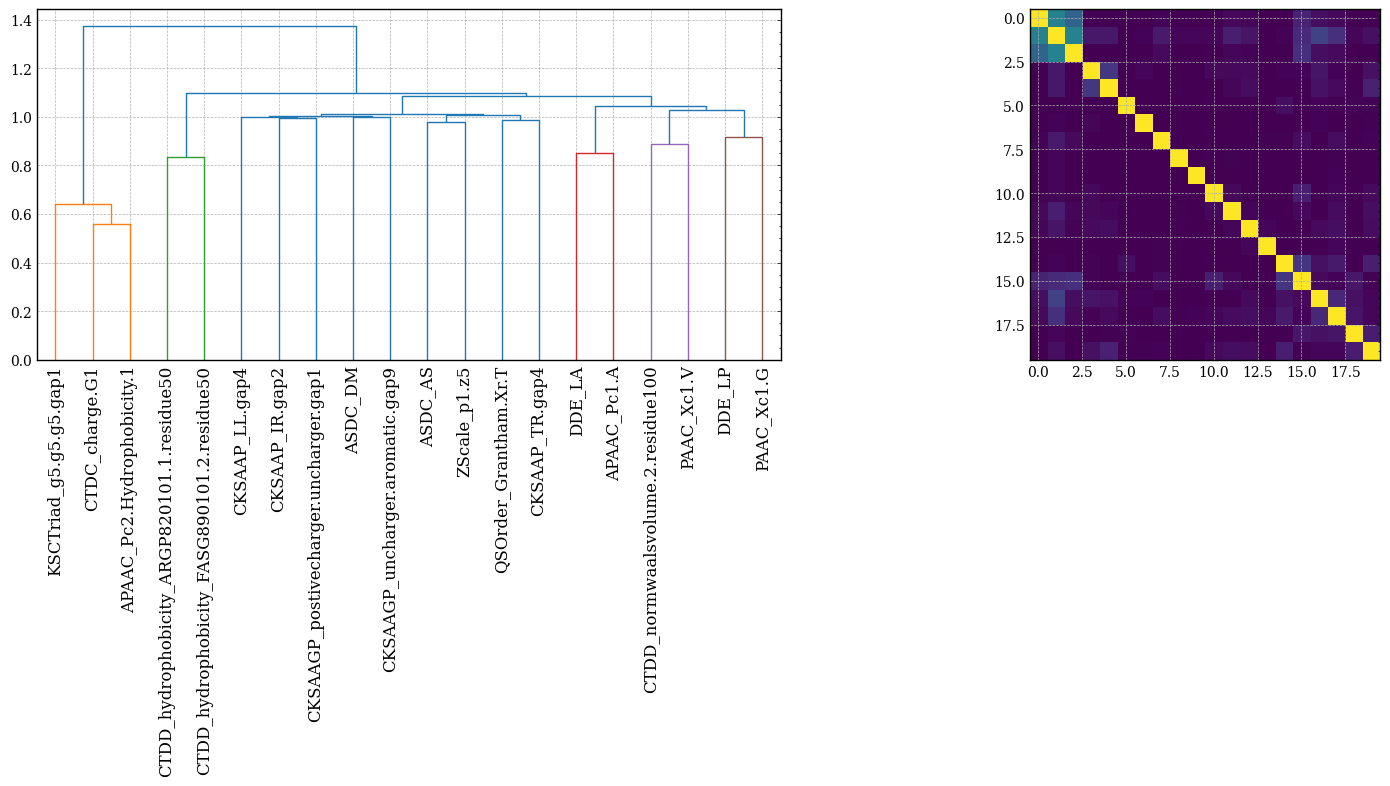

In [34]:
dist_linkage = features_clustering(corr_matrix, show=True)

## Compute Shapley values for optimized sequences

In [35]:
masker = shap.maskers.Partition(train[selected_features], clustering=dist_linkage)
explainer = shap.PartitionExplainer(models['refit_model'].predict, masker)
shap_values_test_optimized = explainer(test_optimized[selected_features])

Partition explainer: 31it [00:43,  1.81s/it]                                    


Original sequence: GEGAHVKIVANLPYYITTPILMQLLRAKISW


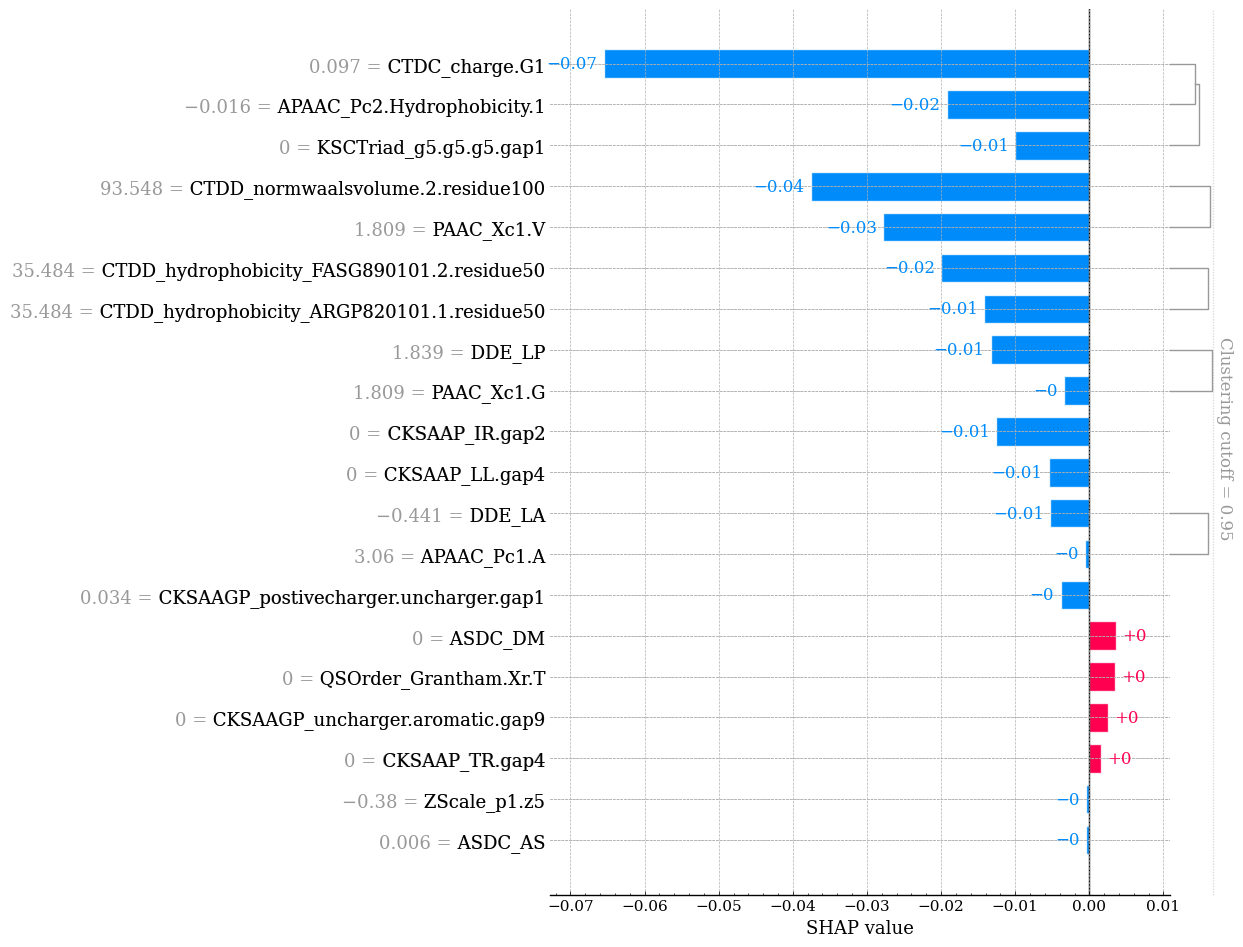

Optimized sequence: WEGAHAKIAARLPYYLTTPLLMQLLRAKMKW


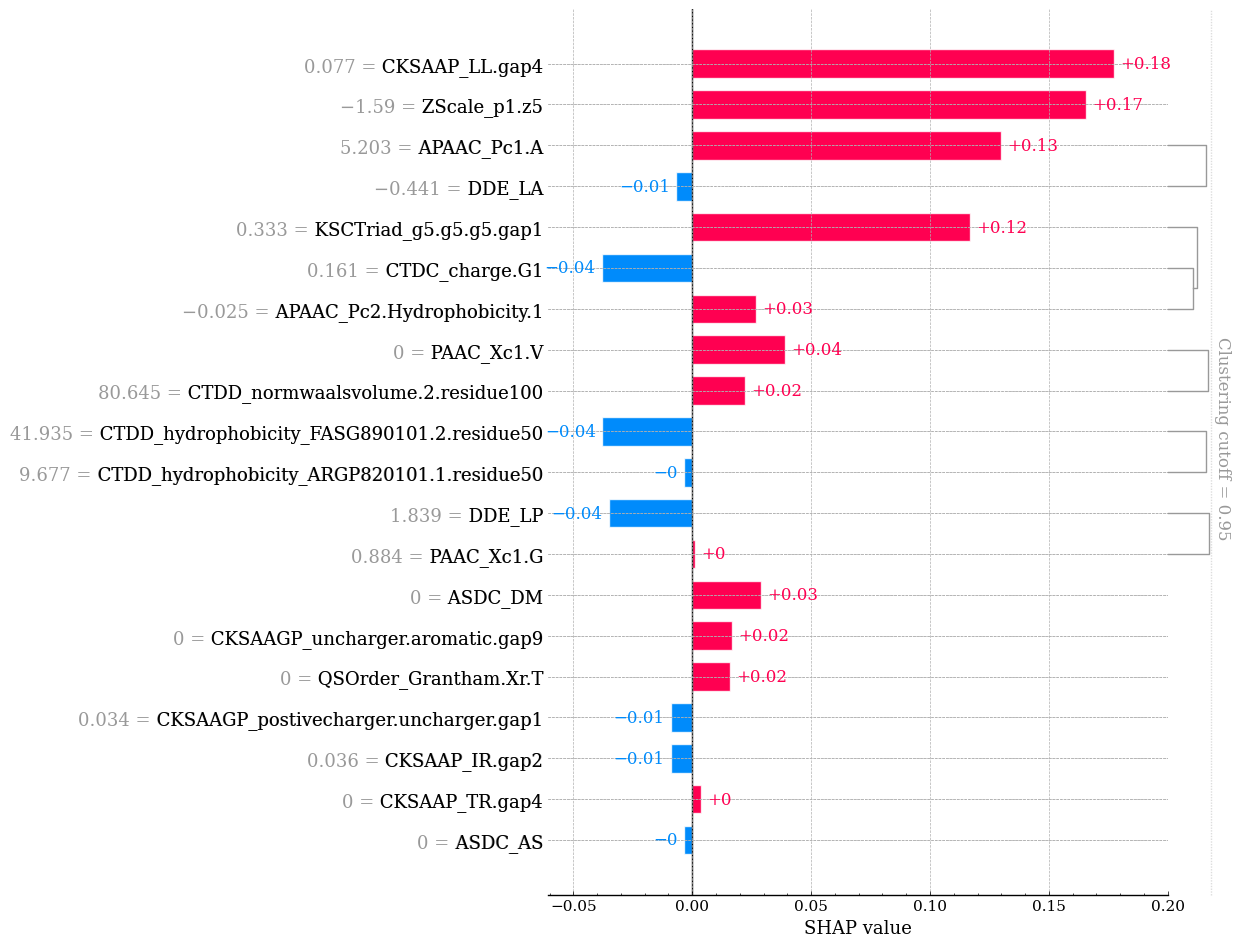

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: GEPWKVCVN


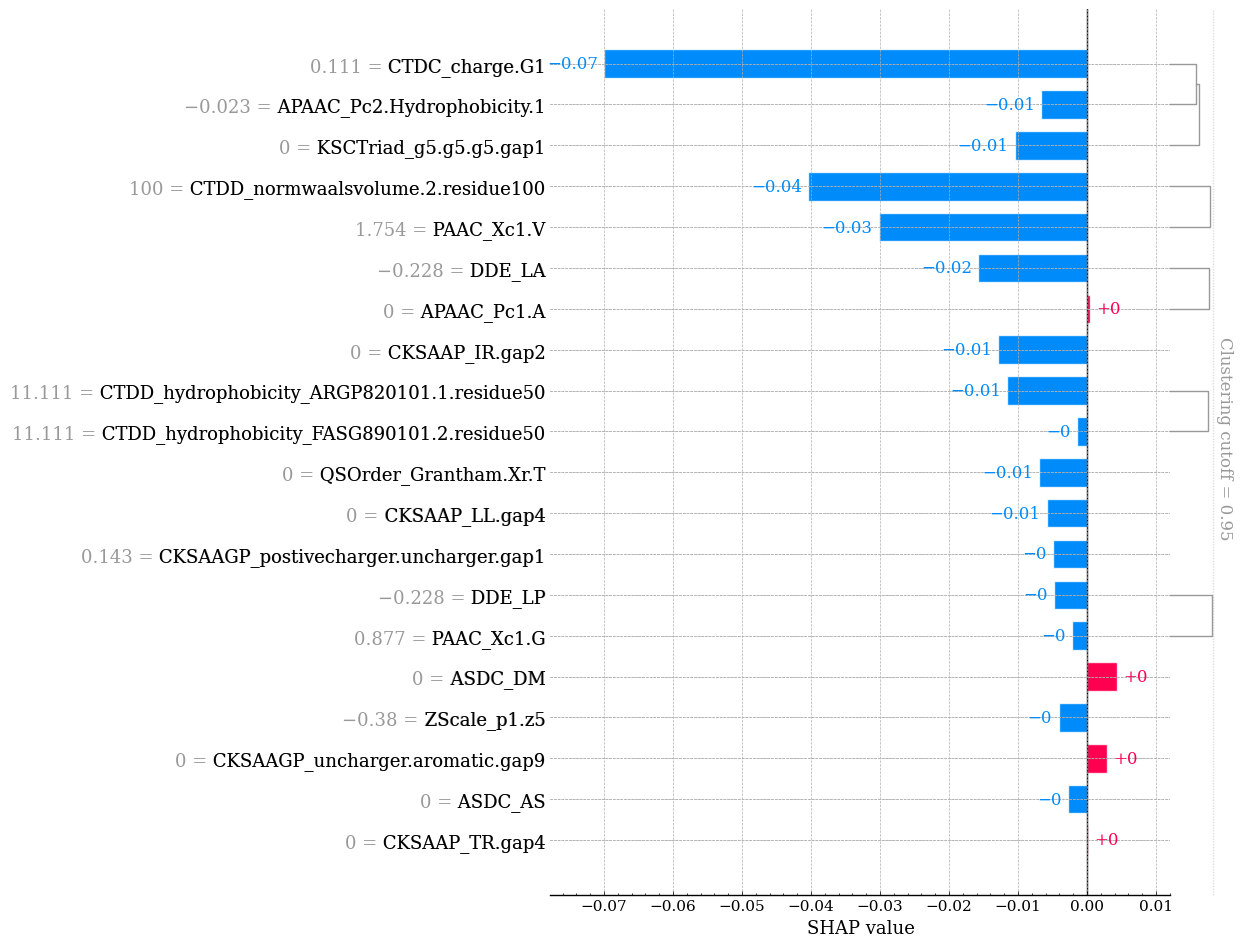

Optimized sequence: GKPWKICVR


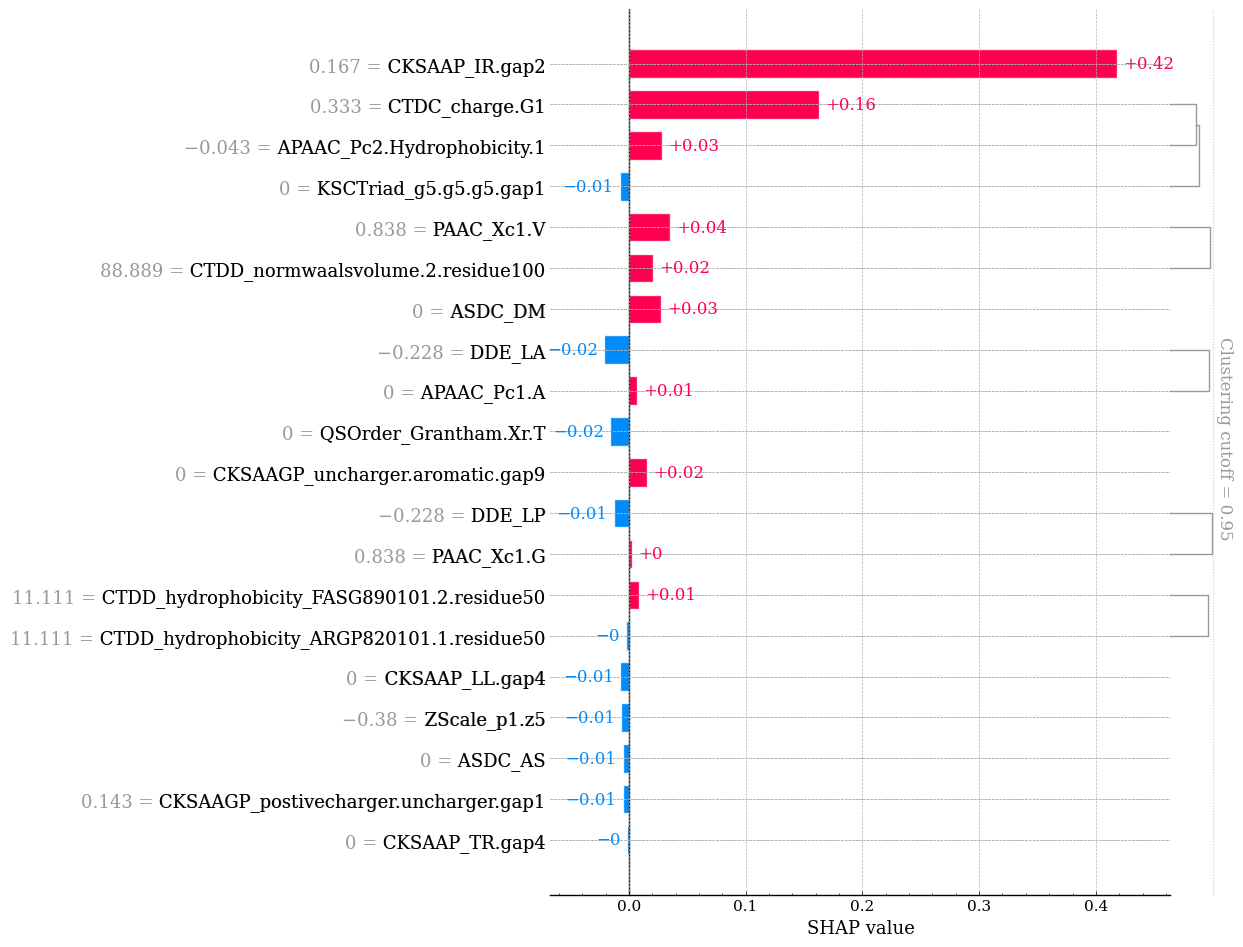

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: VISANIRTTISGMDDSGGTGSRQKFRKLRKIERE


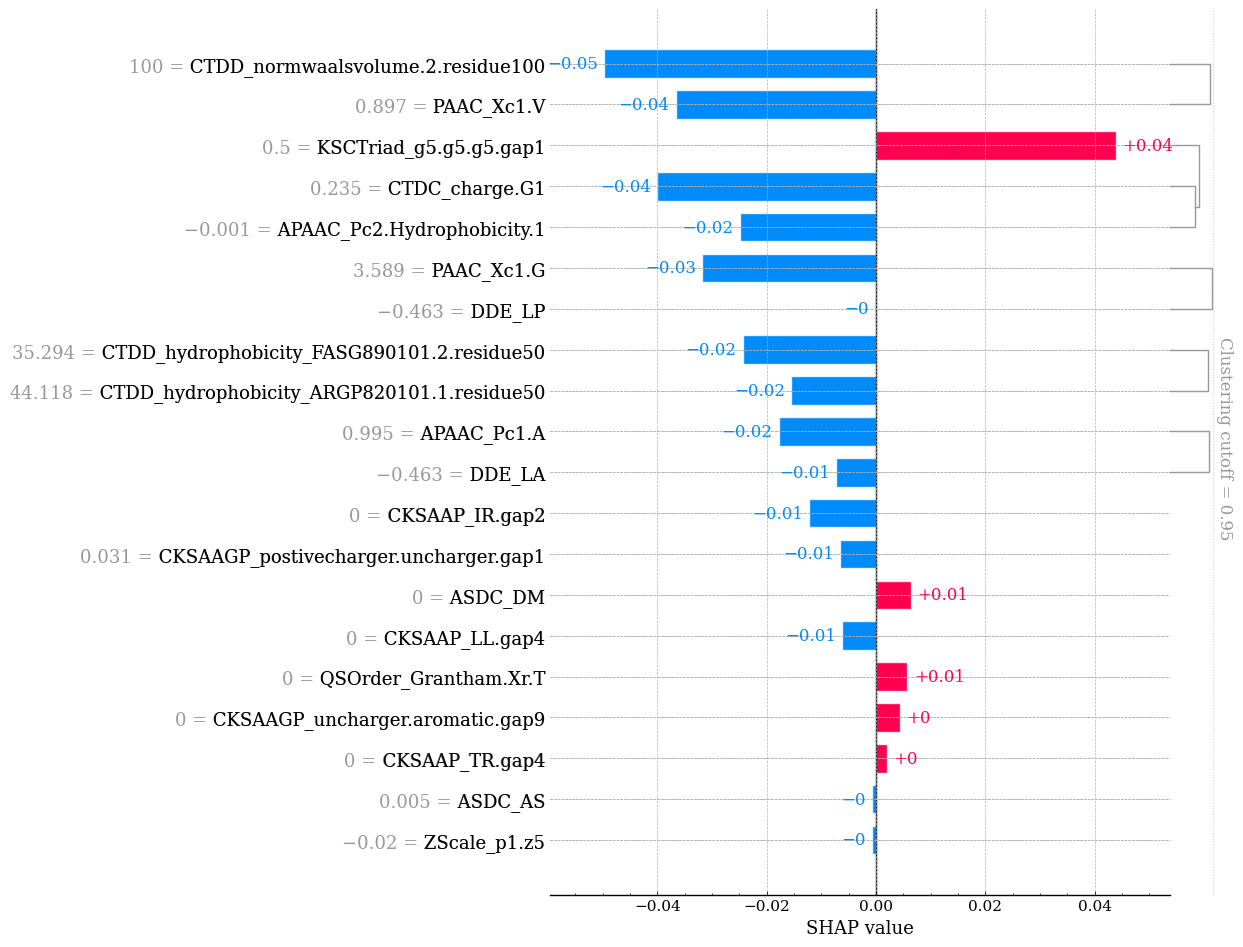

Optimized sequence: CISANIRTTISGMDDSGGTGKRKKFRKLRKIKRK


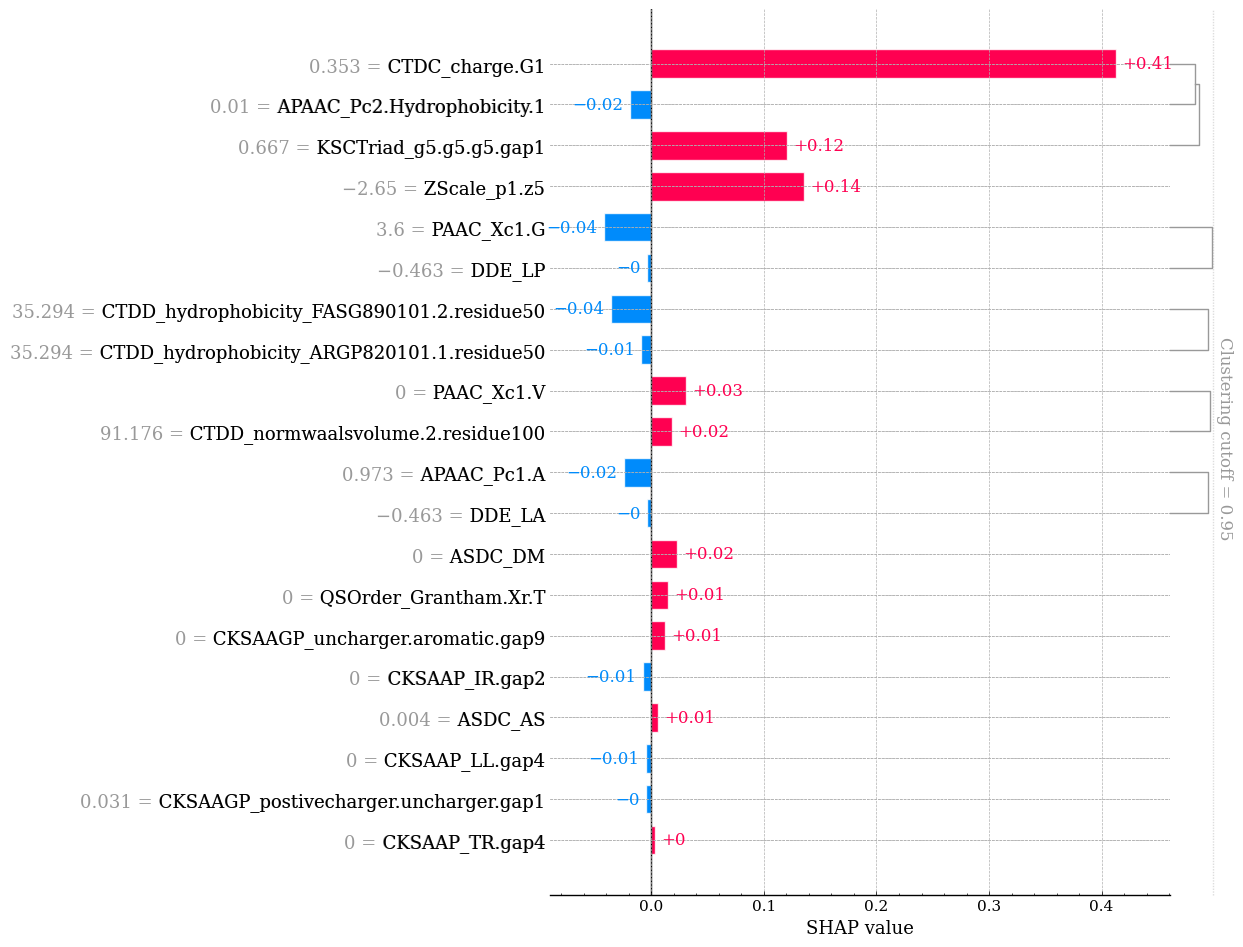

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: LDPIVAKRVRHILTENARTVEA


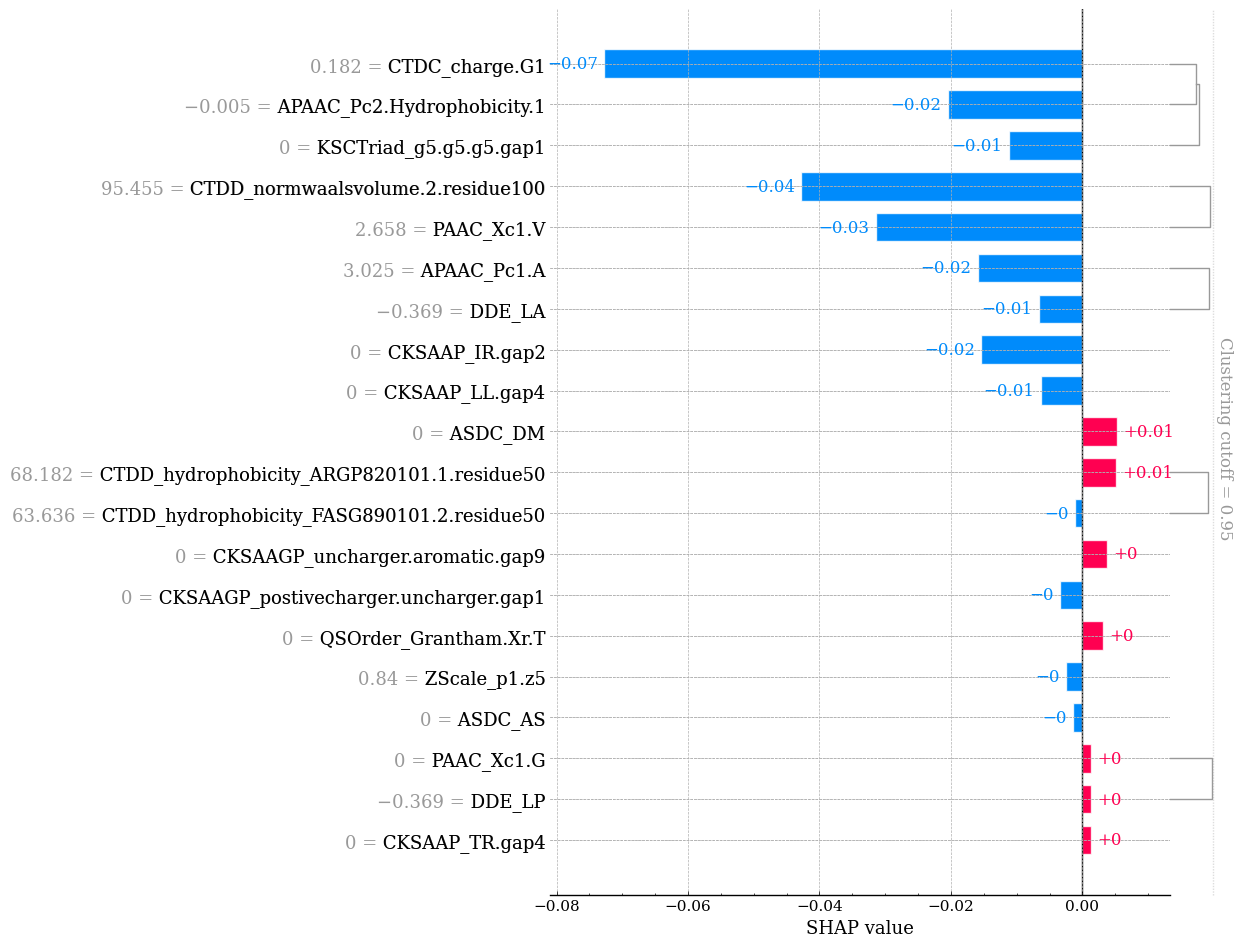

Optimized sequence: LDPIVKKRRRHILTENTRTVEA


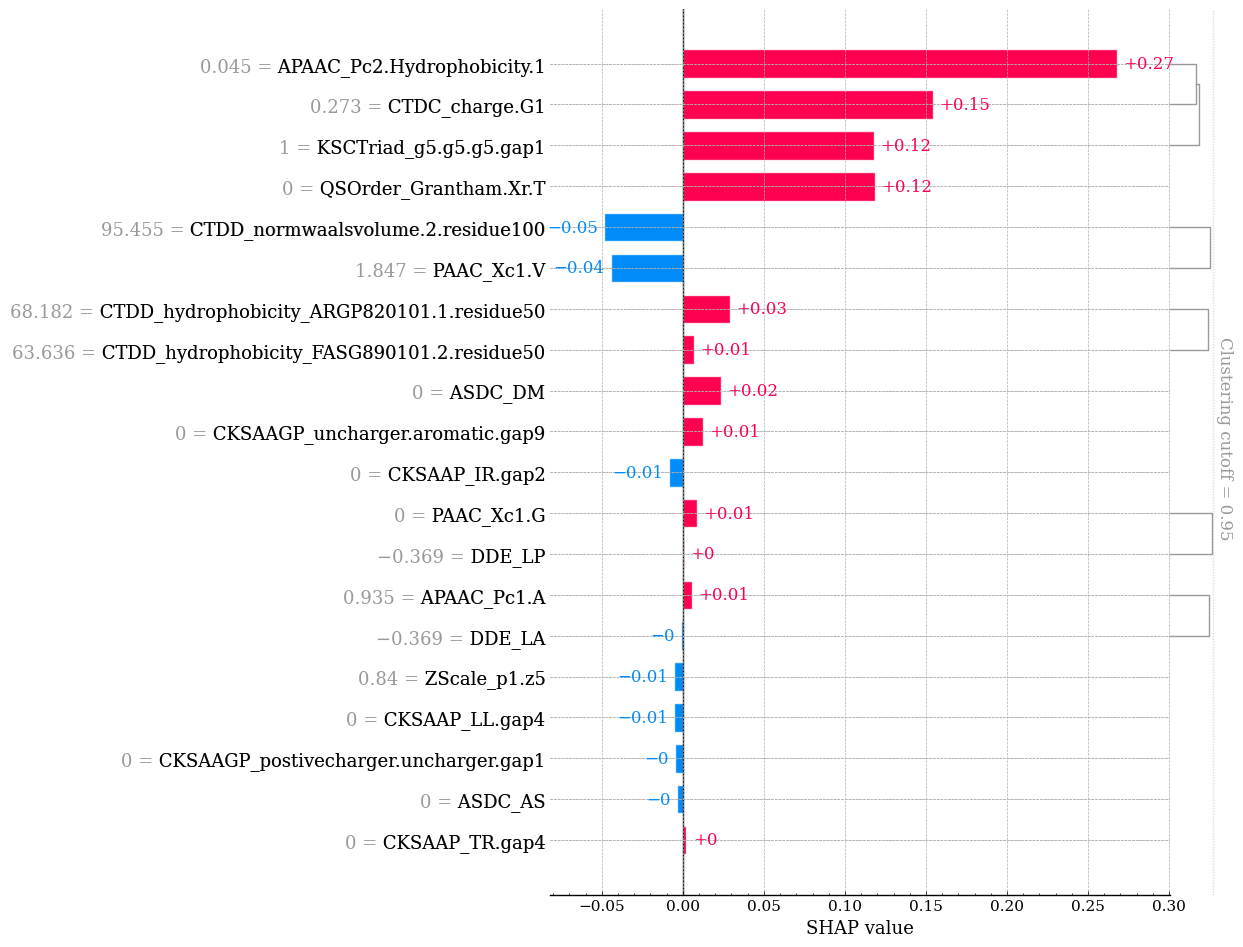

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: DAWRMHMQEFVAQLETR


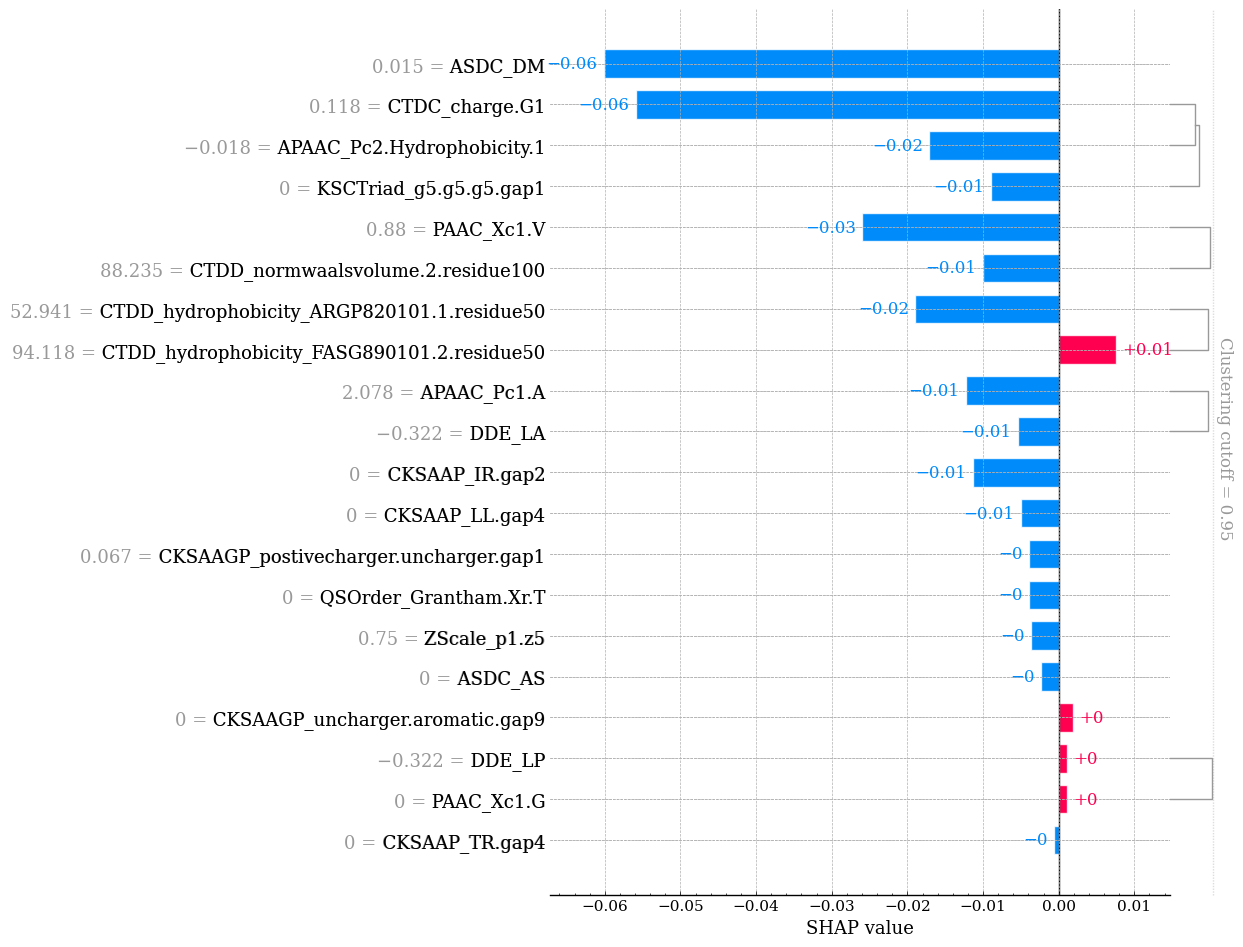

Optimized sequence: KAWRMHMQKFVARLKTR


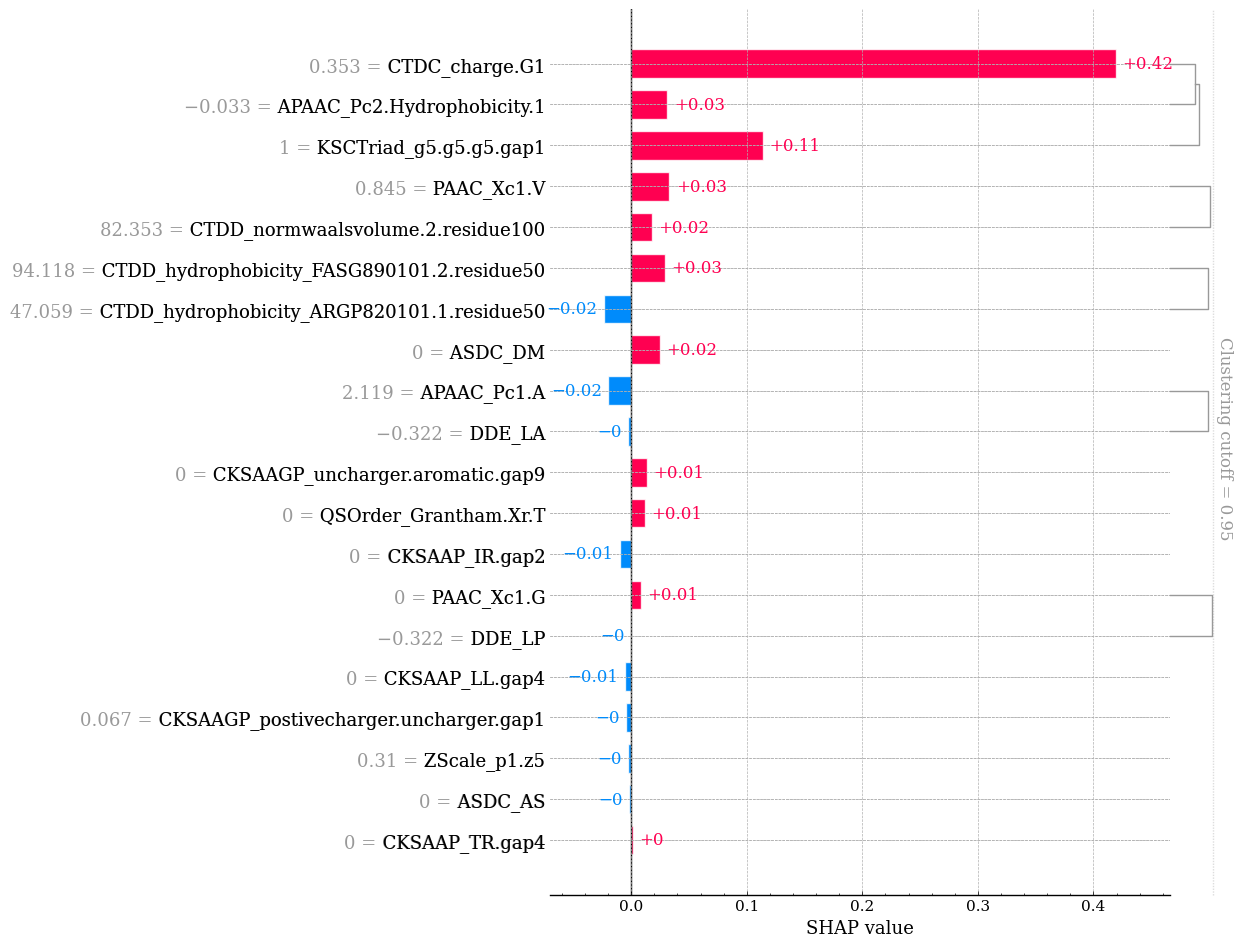

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: IFSNTALVNCMRQTLQDTGHNP


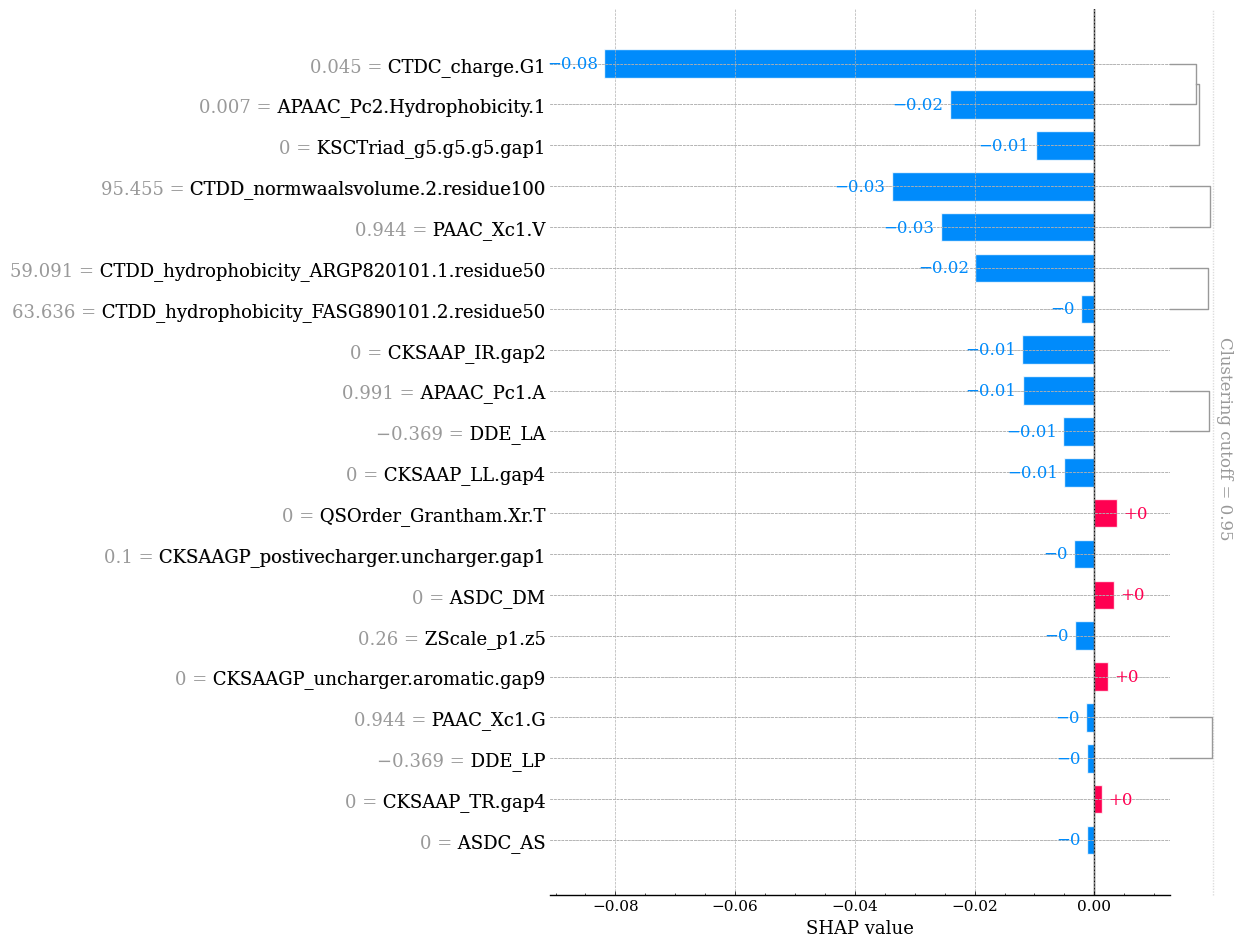

Optimized sequence: IFKRTALINCRRRTLQDTGHNP


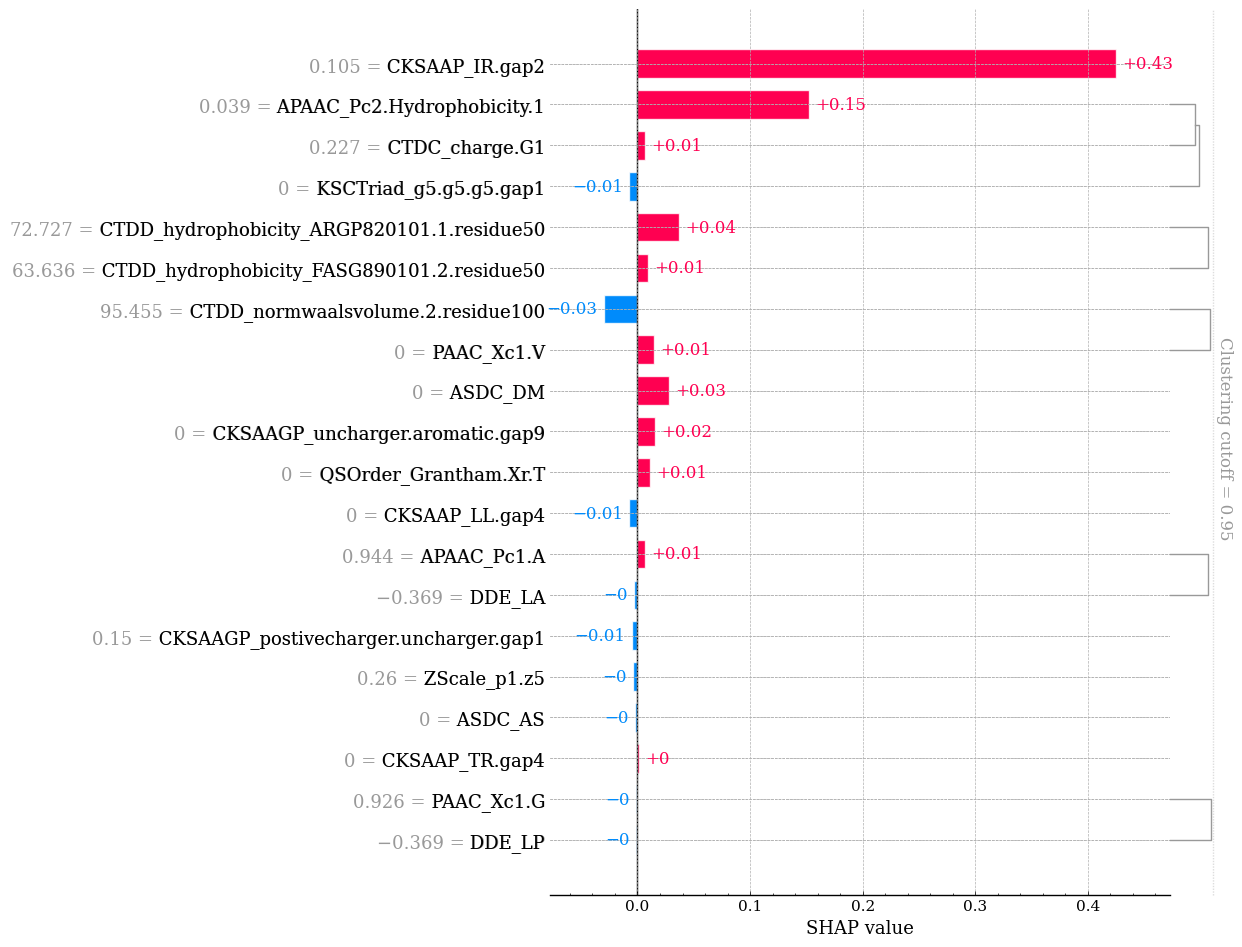

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: ETGGEFGKGVIRAELDVKPDLWFFGCHF


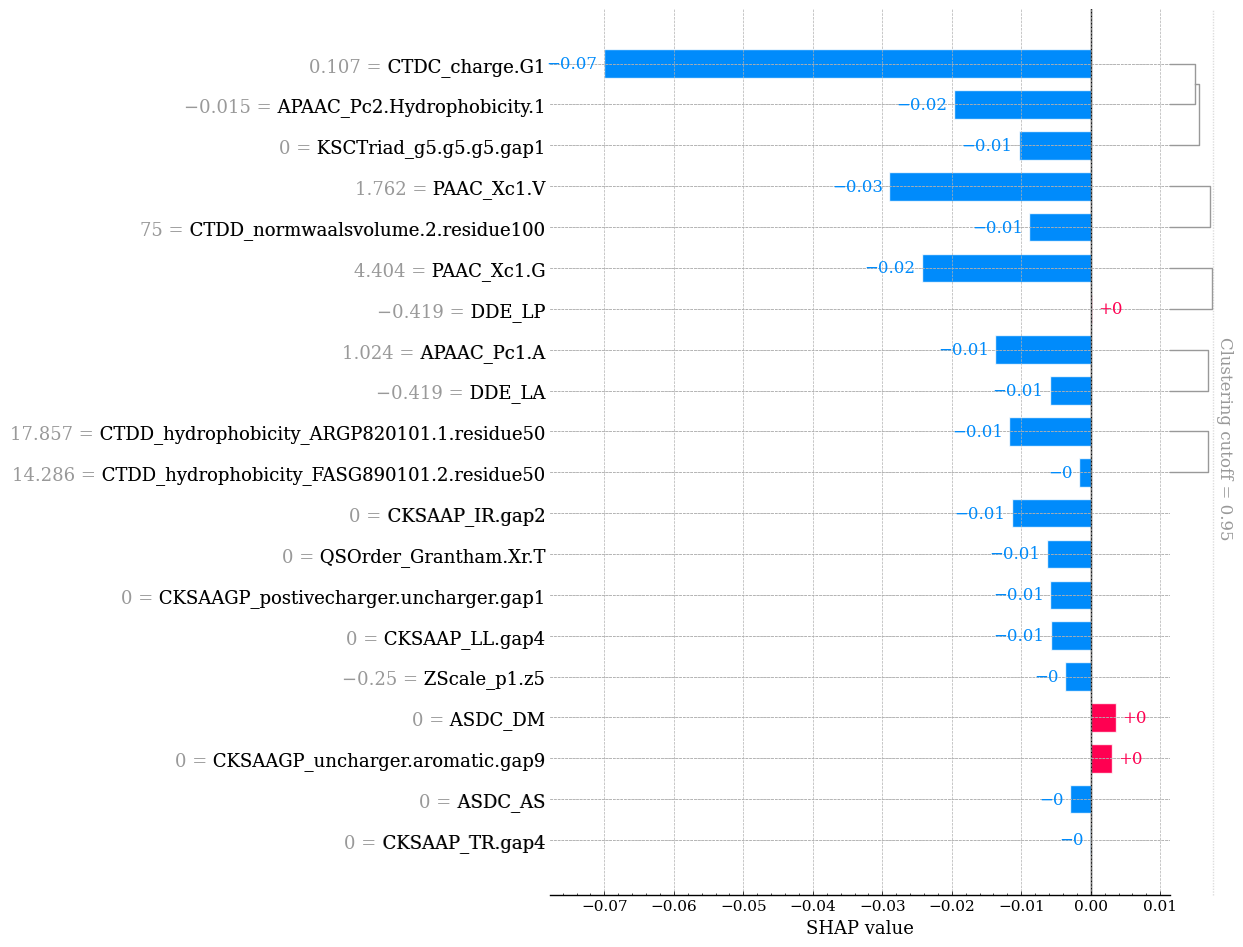

Optimized sequence: WTGGKFGKGKIRGKLDIKPDLWFFGCHF


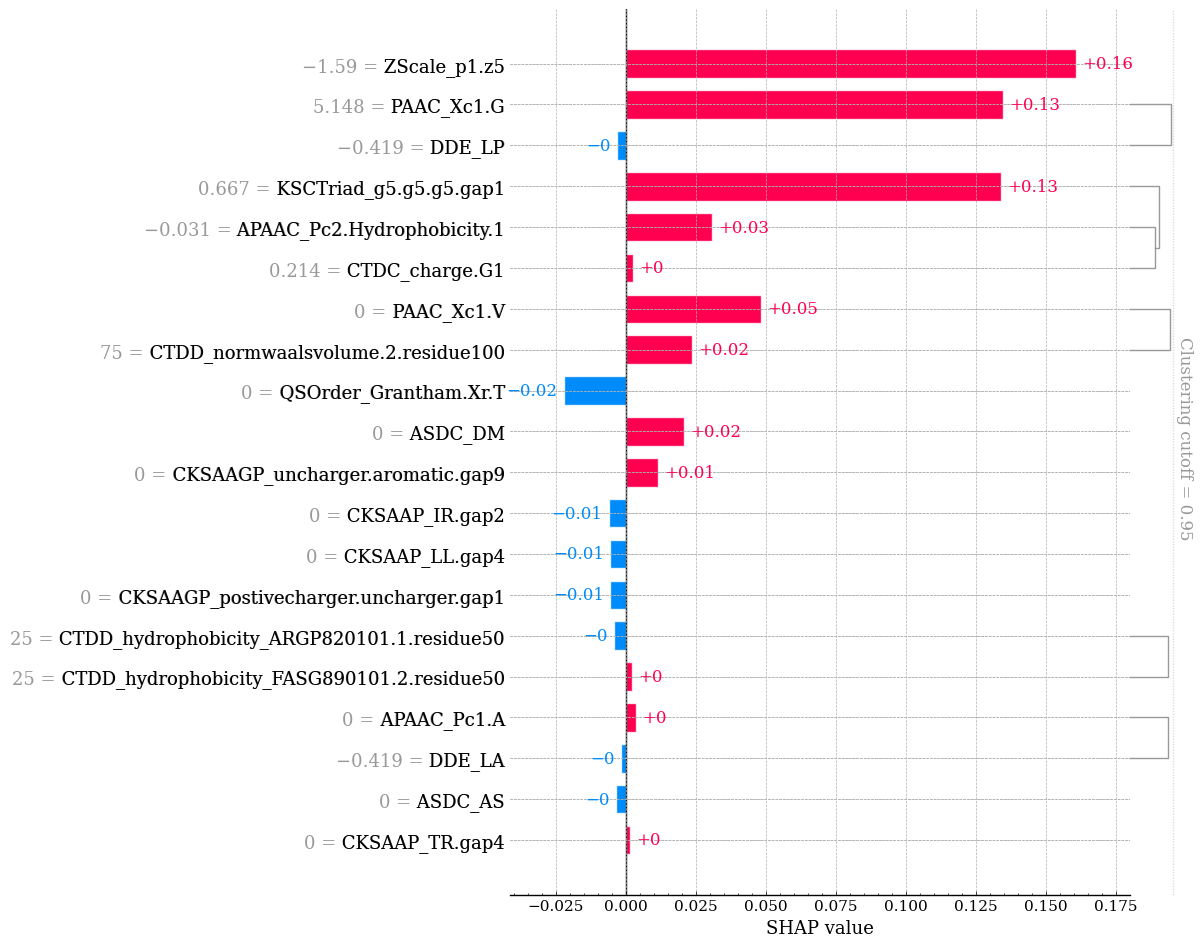

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: TIVARSIAVGLQEAVREMKRLVQN


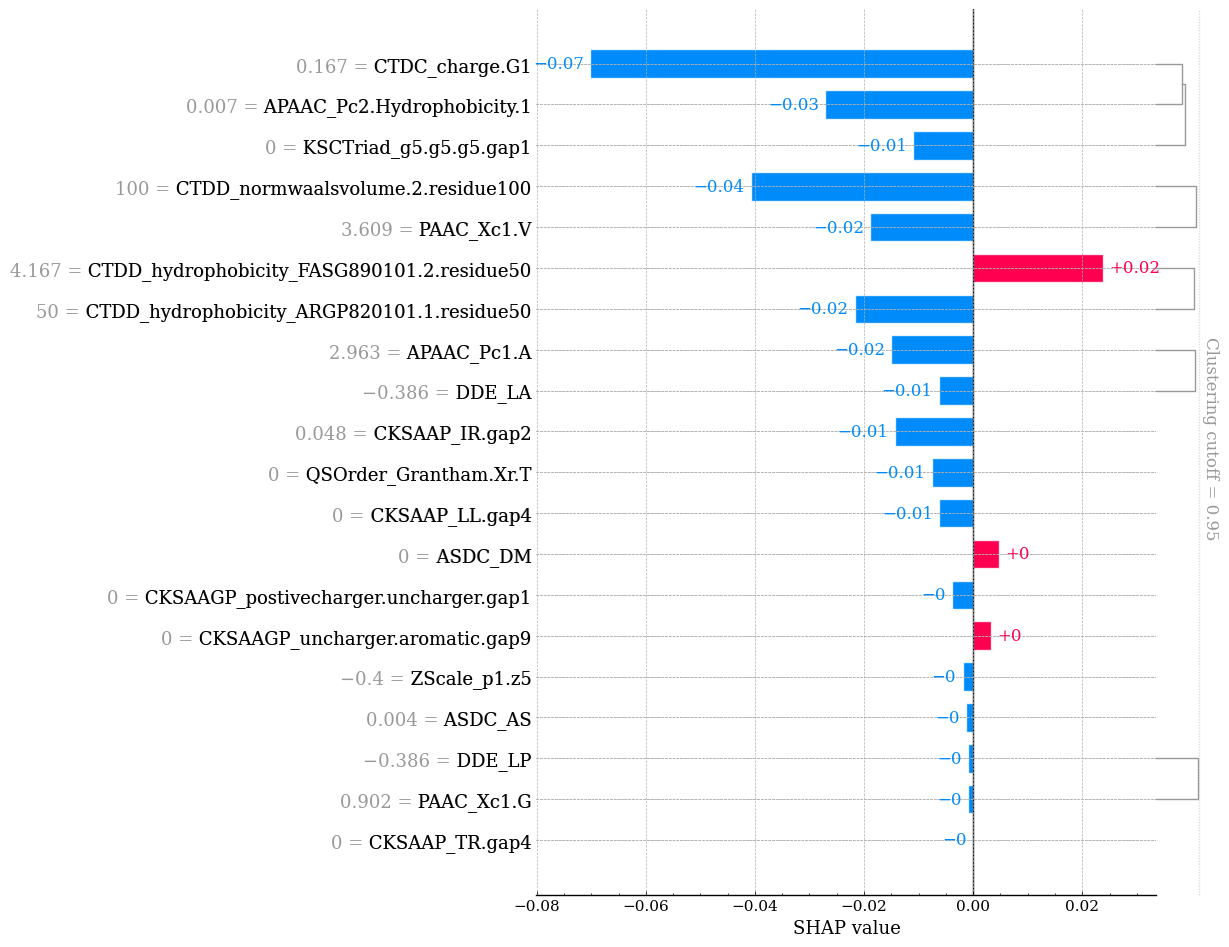

Optimized sequence: TIVARSIAVGLQEAIRRRKRLVQN


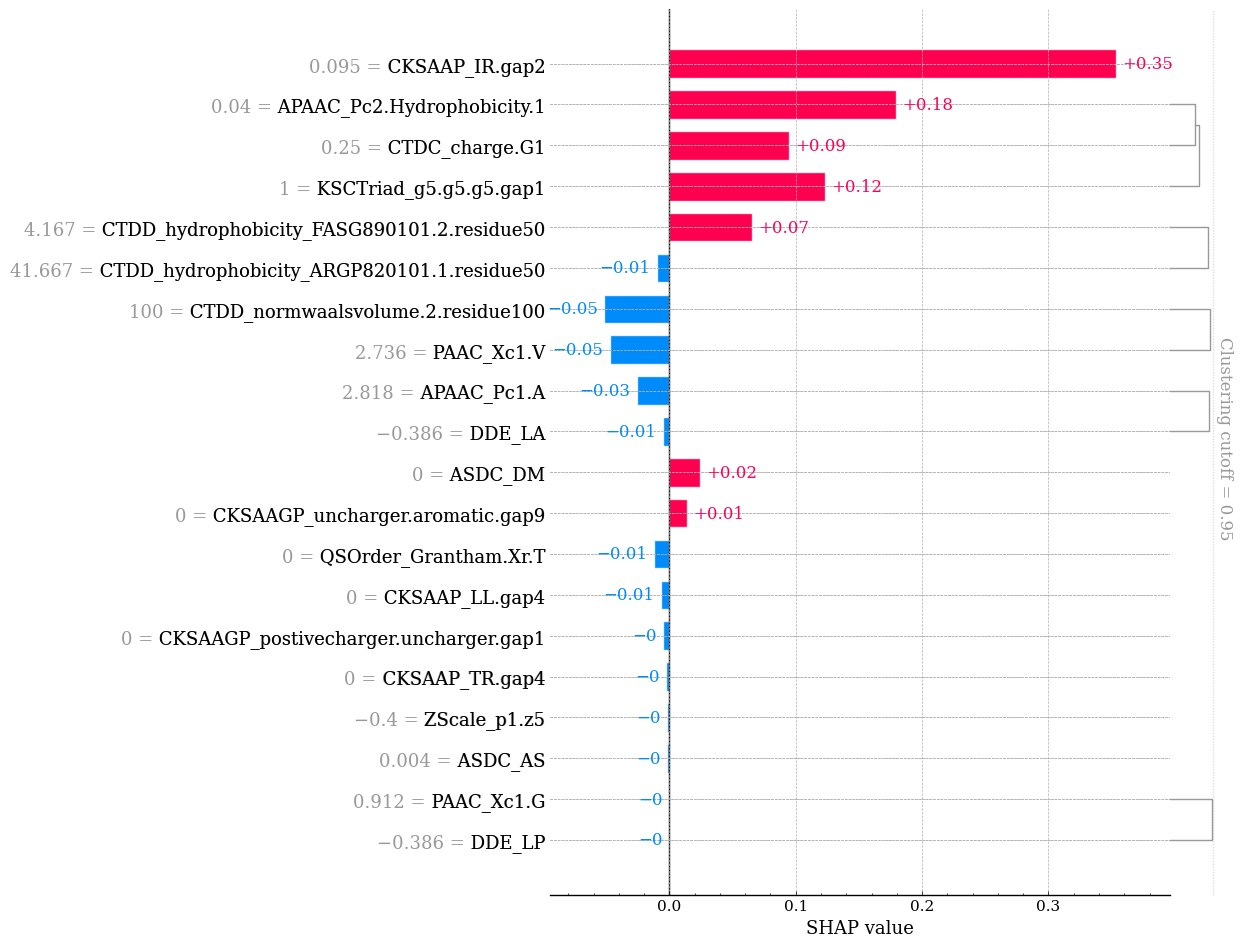

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: PNILTGAIVGGP


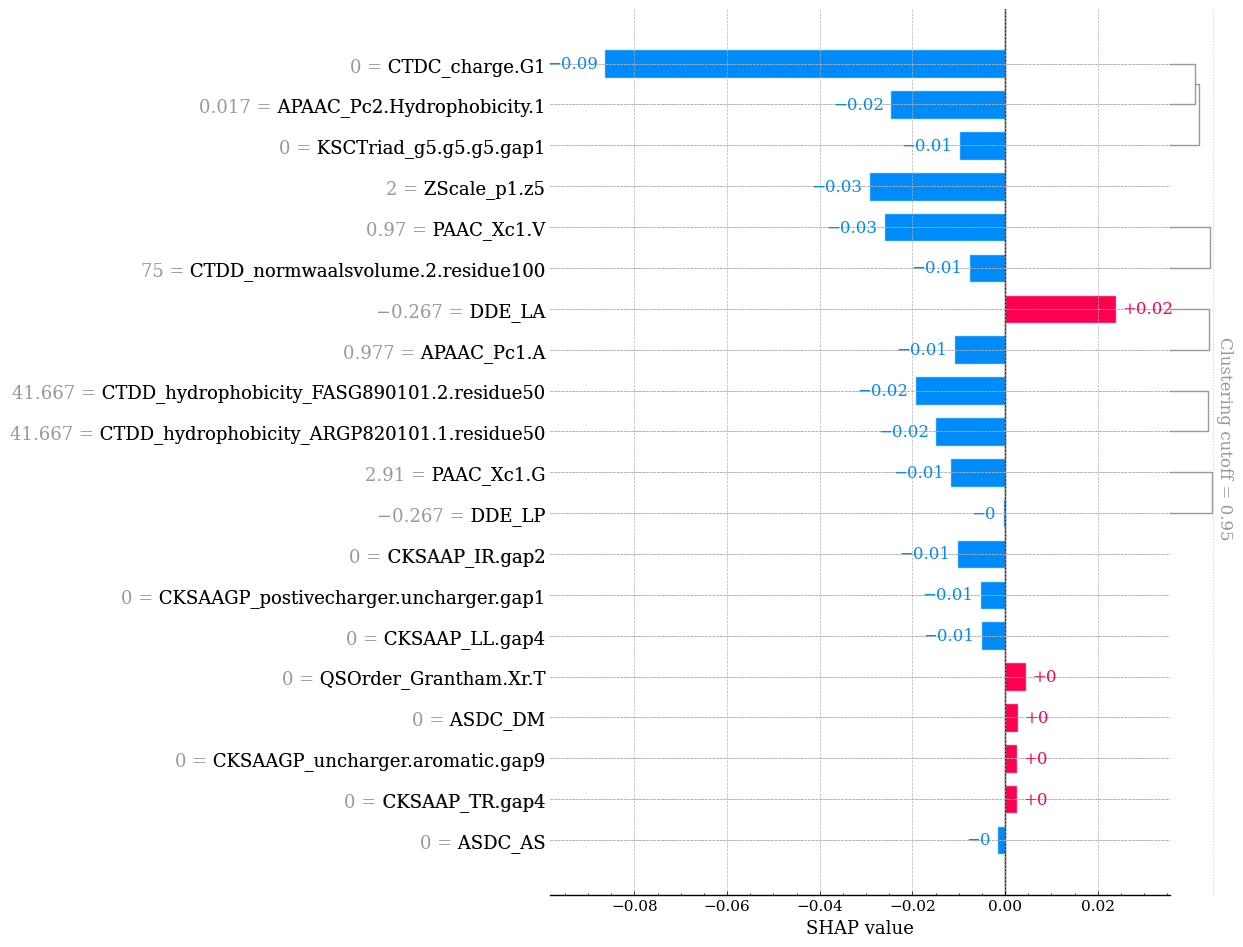

Optimized sequence: PNILTRAILGGP


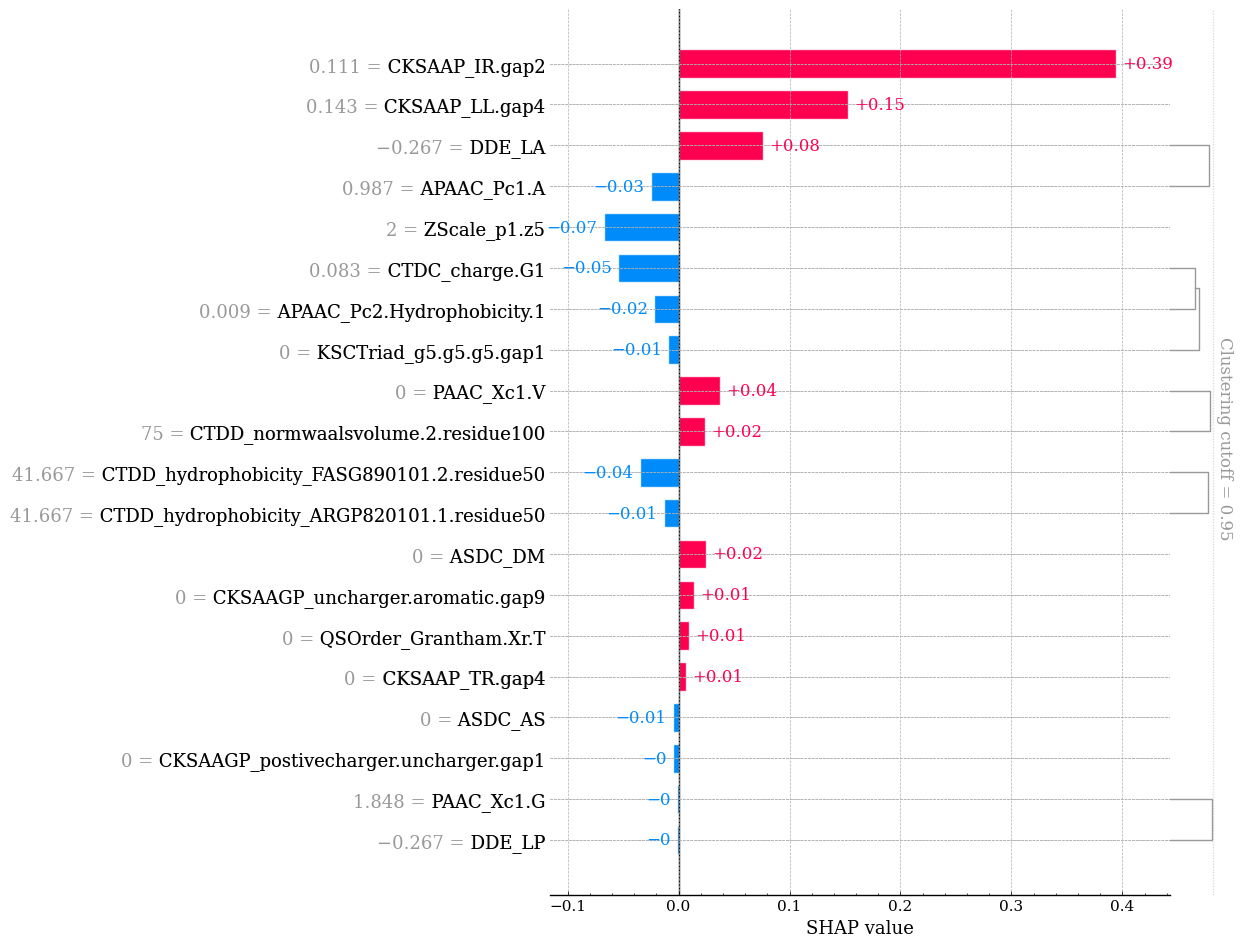

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: TAVEQKYRFFSYGDAM


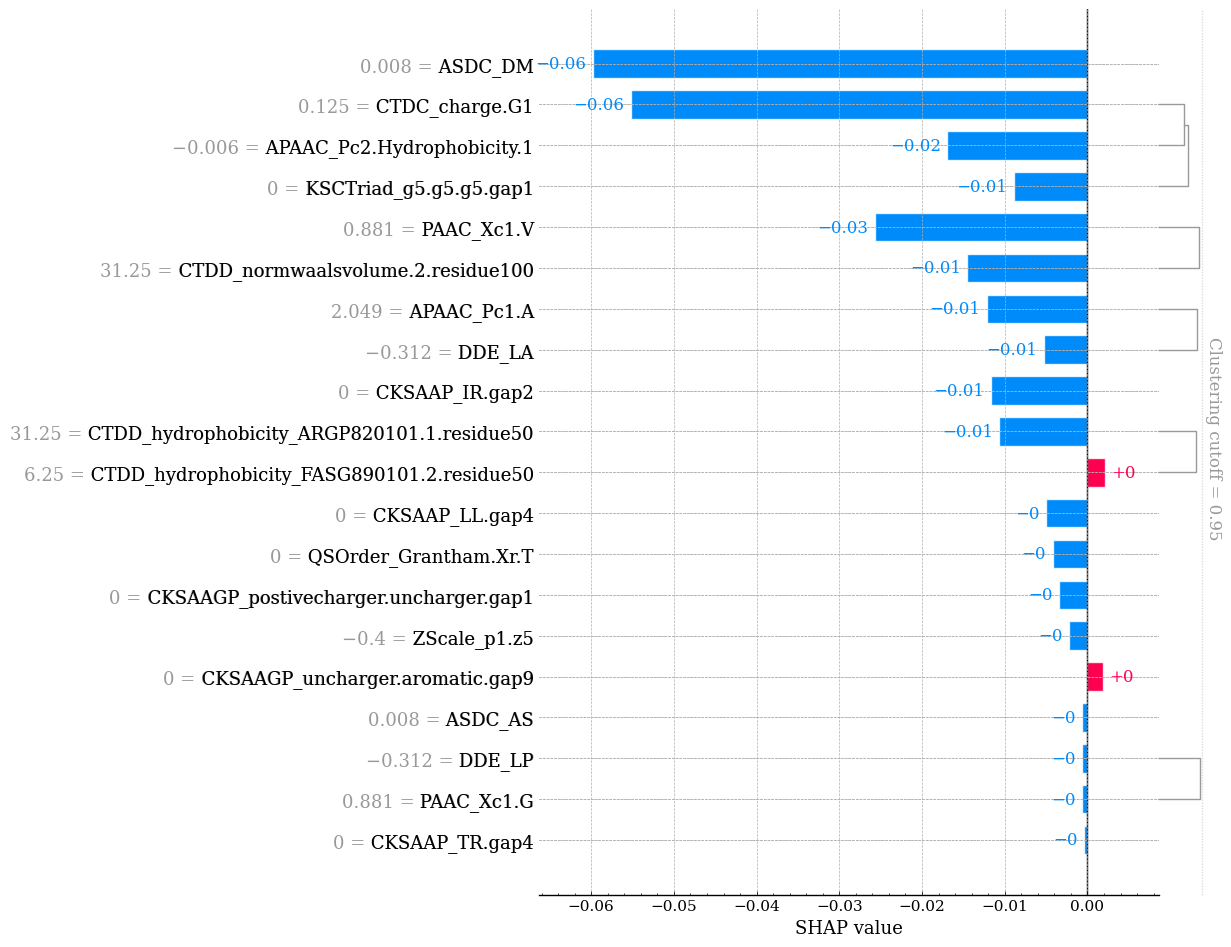

Optimized sequence: CAAKKKYRFFSYGDAM


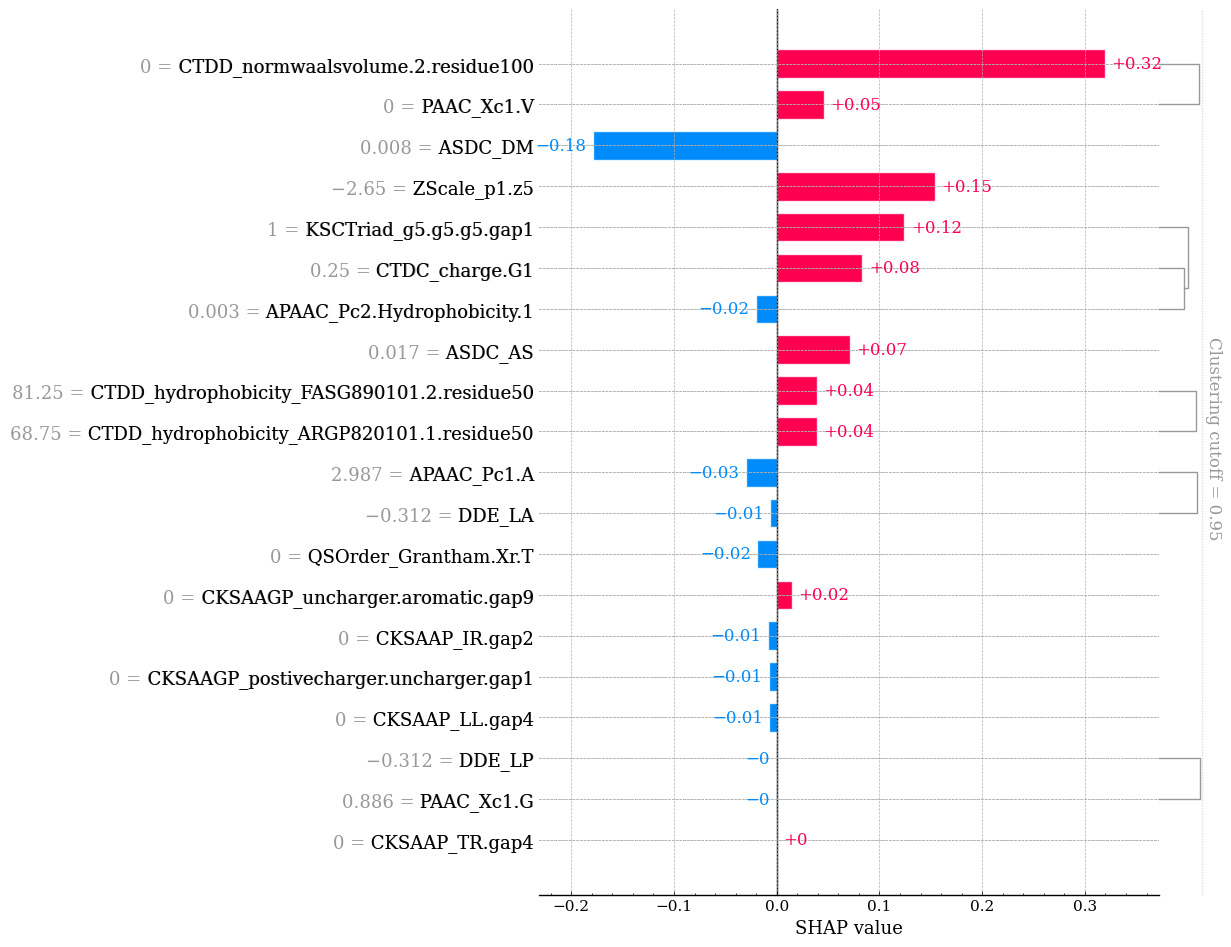

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: YLYVDCSNIPSISLDPGFRSMSDQNQVQMLINTYKR


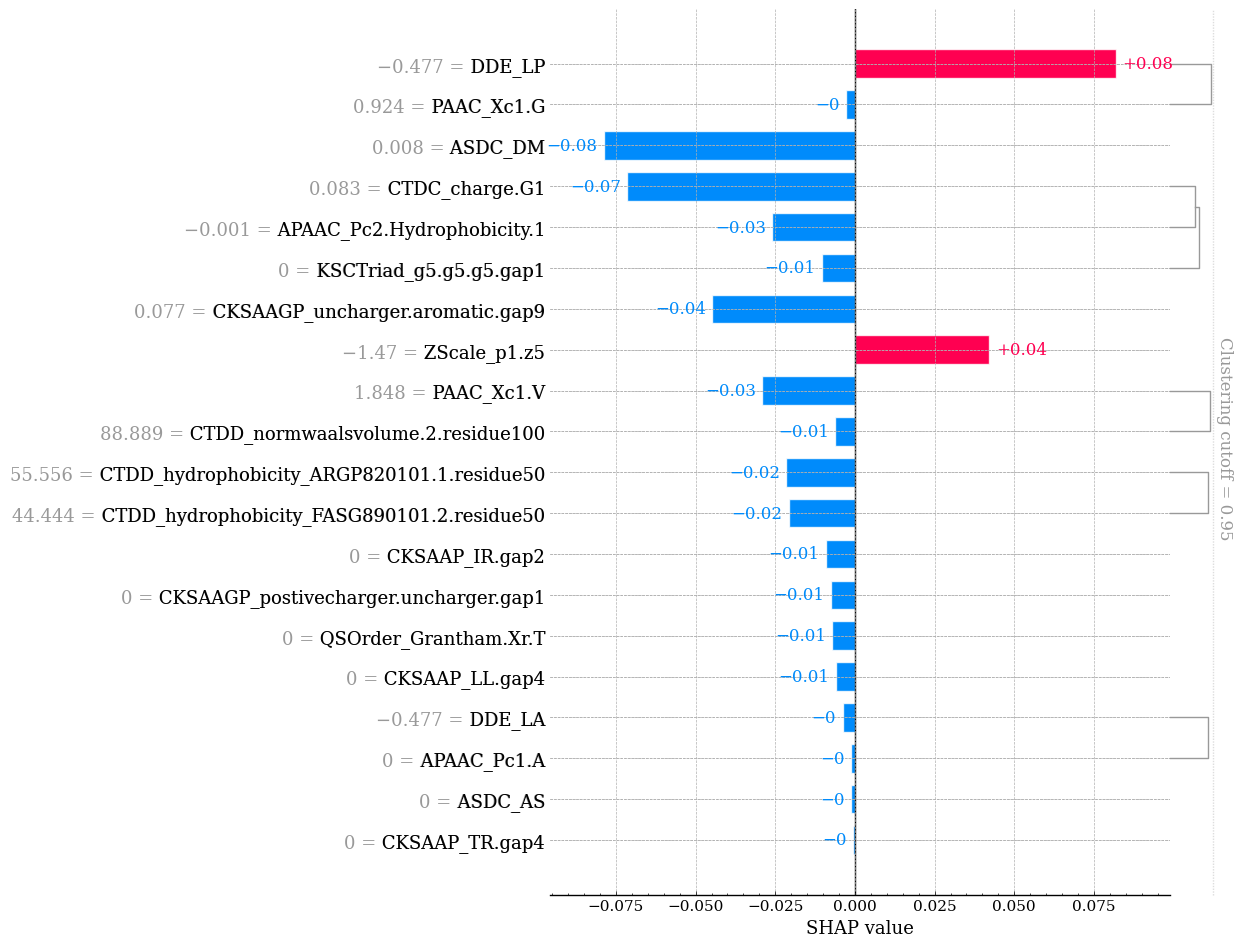

Optimized sequence: YLYIDCSNIPSISLDPGFRSKKKKNRIQRLINTYKR


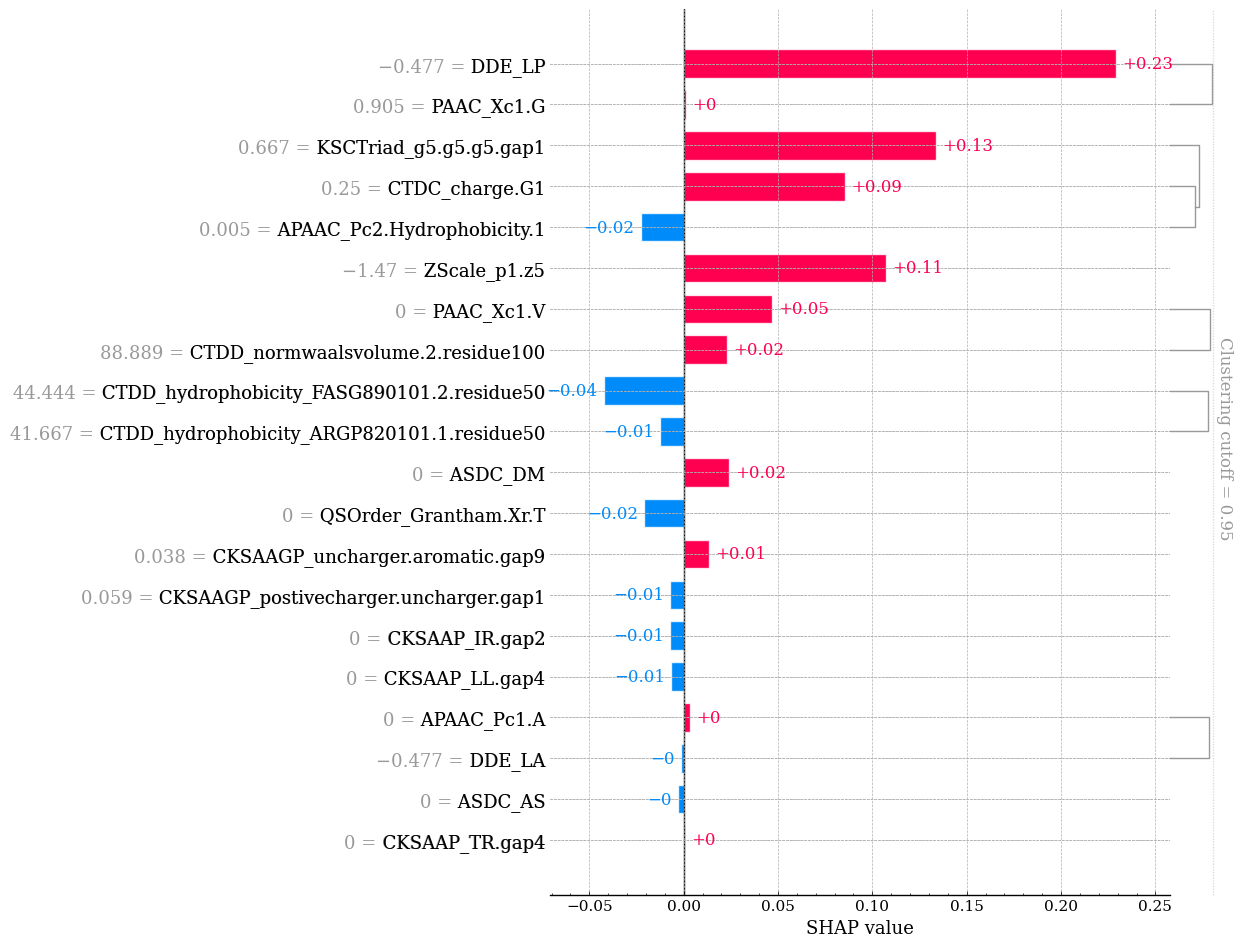

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: SAVEKDREDFREAVVKTLDRLLF


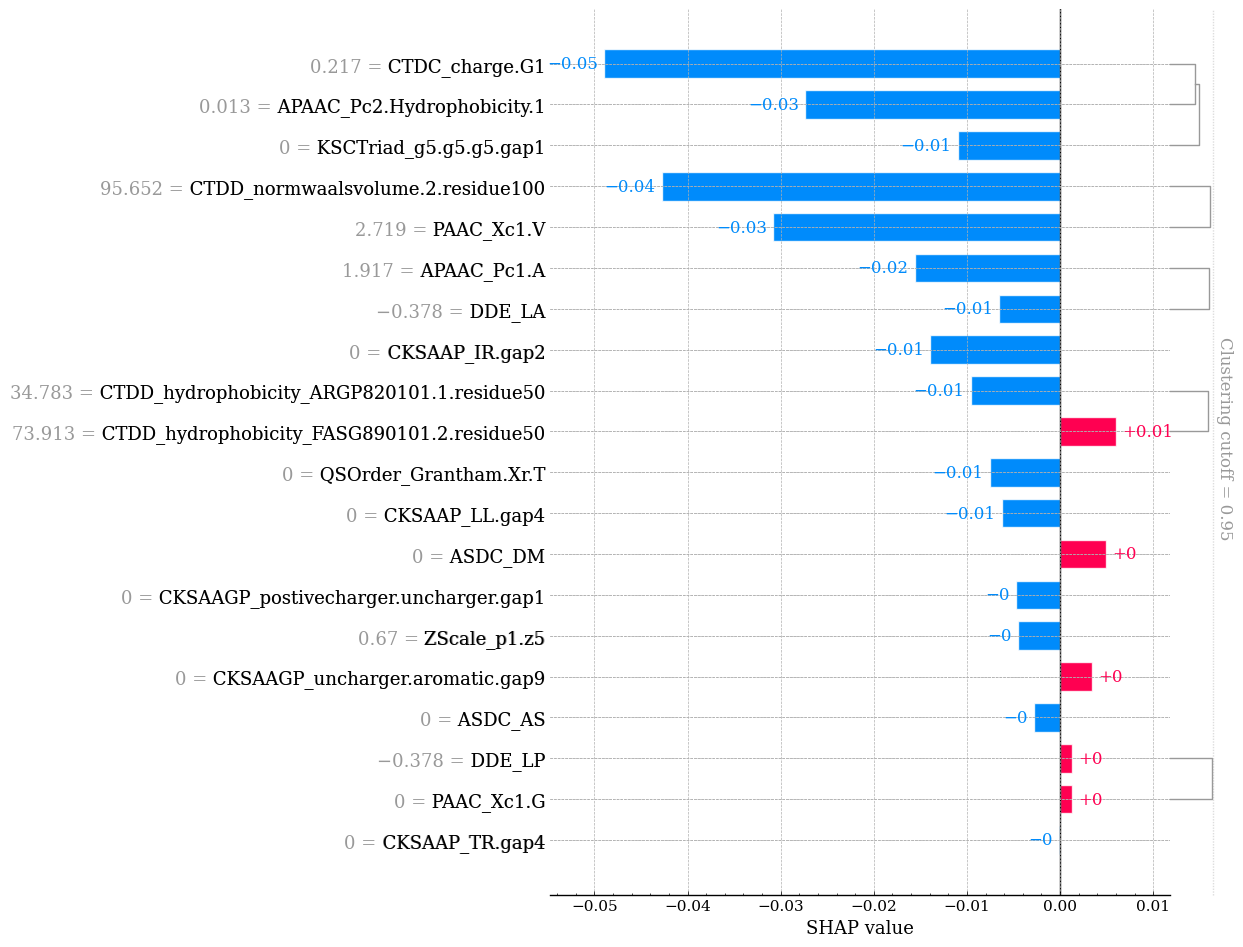

Optimized sequence: SKRRKDREDFREAIIKTLDRLLF


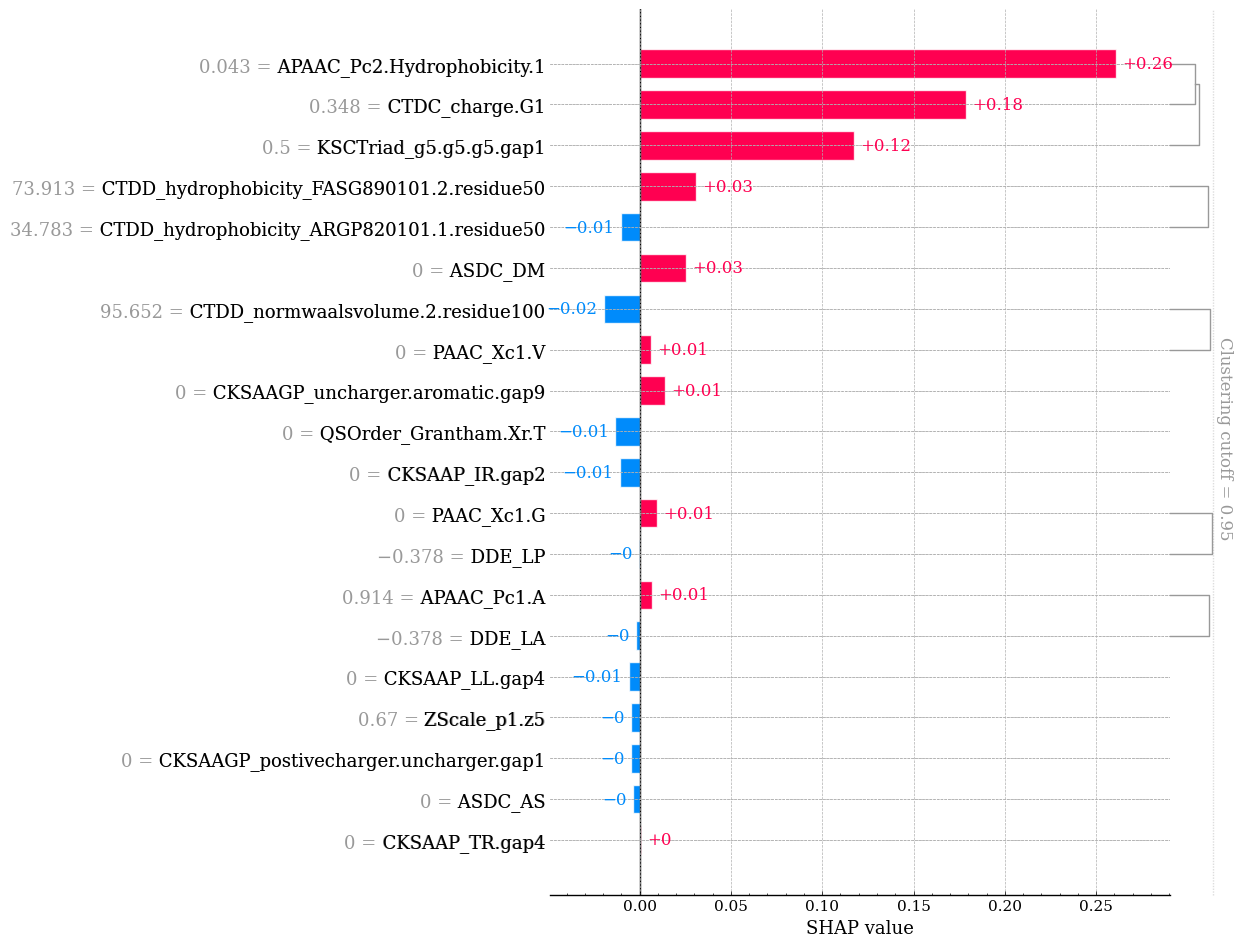

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: QFLQVQNAVIKIQSSY


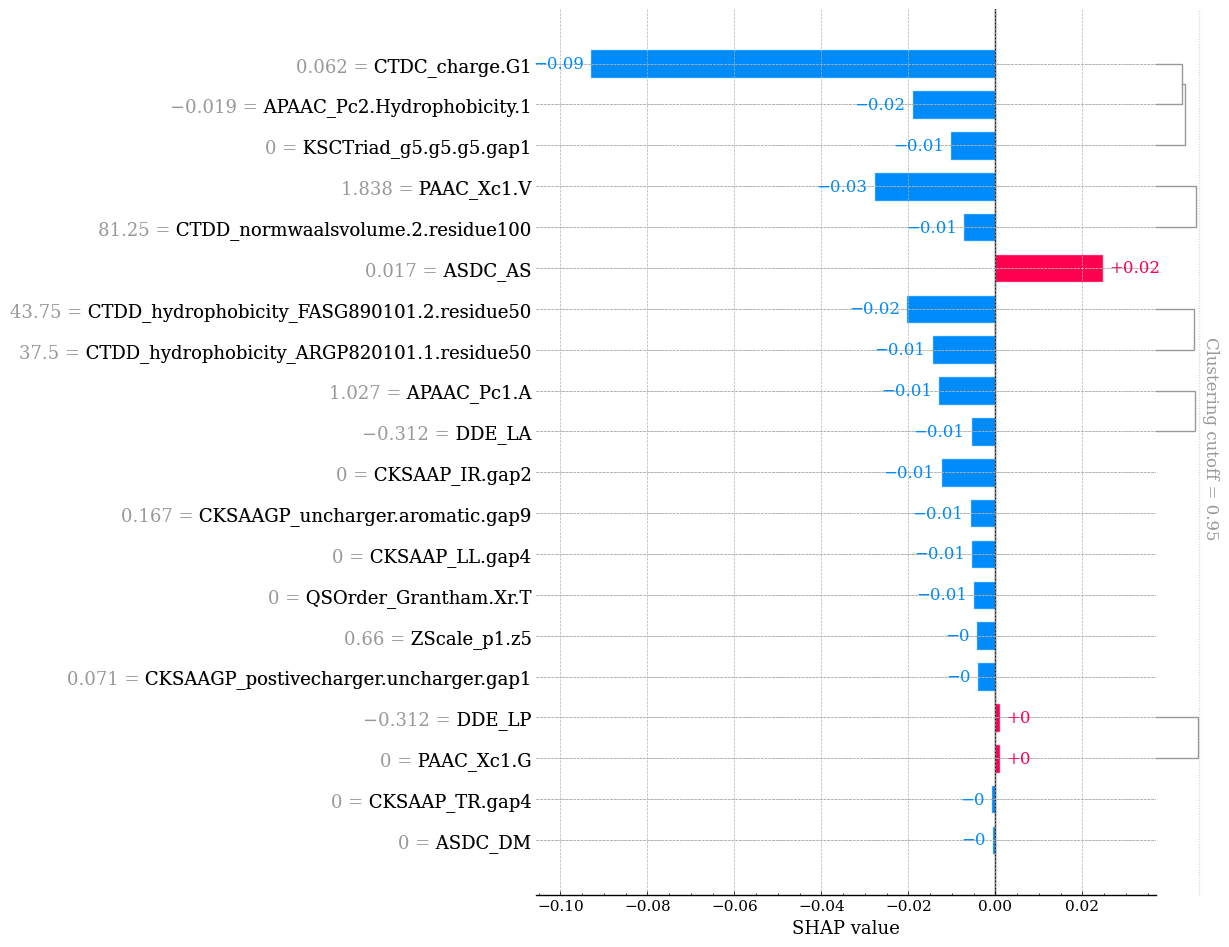

Optimized sequence: QFLQVKNAVIKIRSRY


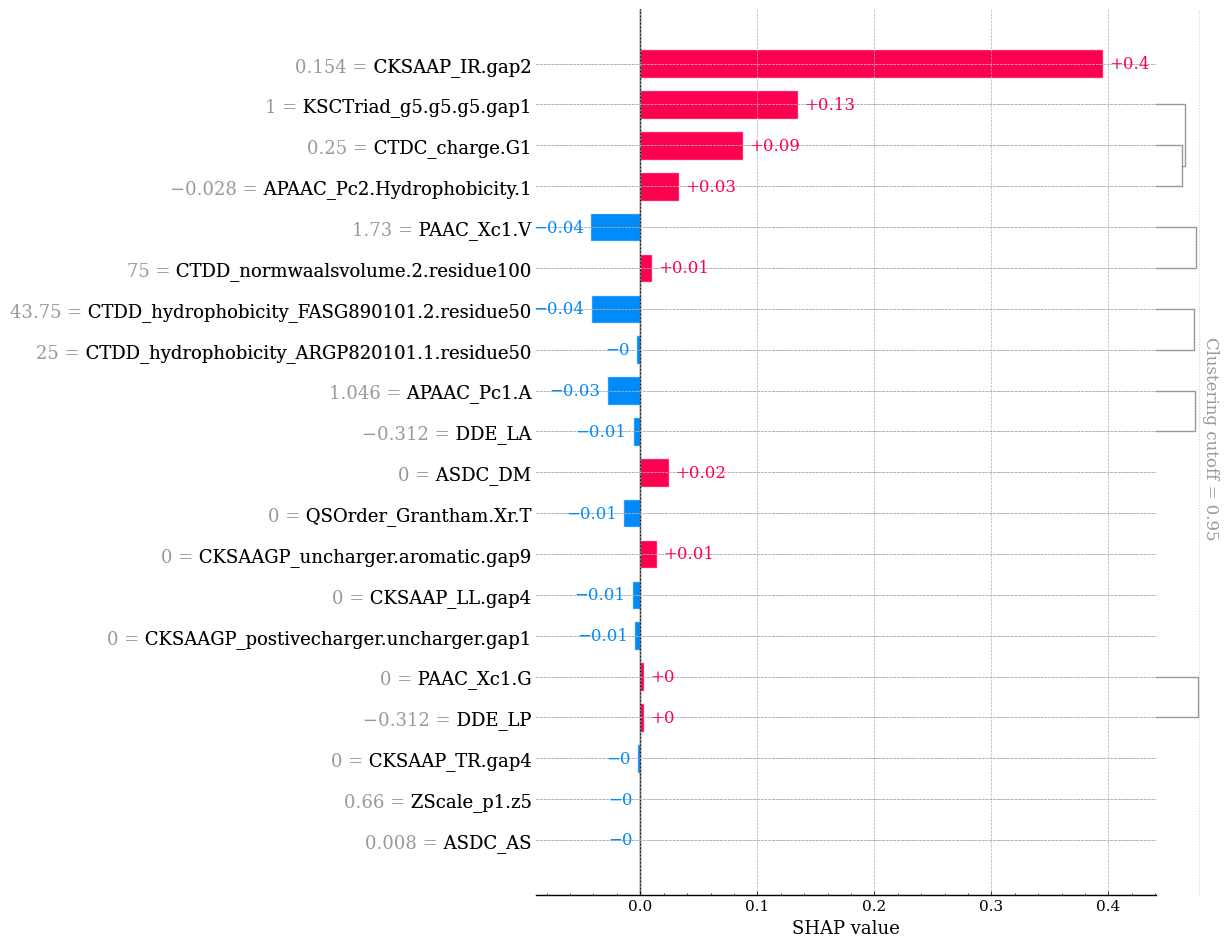

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: ELATQIFEEARKFTYRSWVRPCVVYGGAPIGNQM


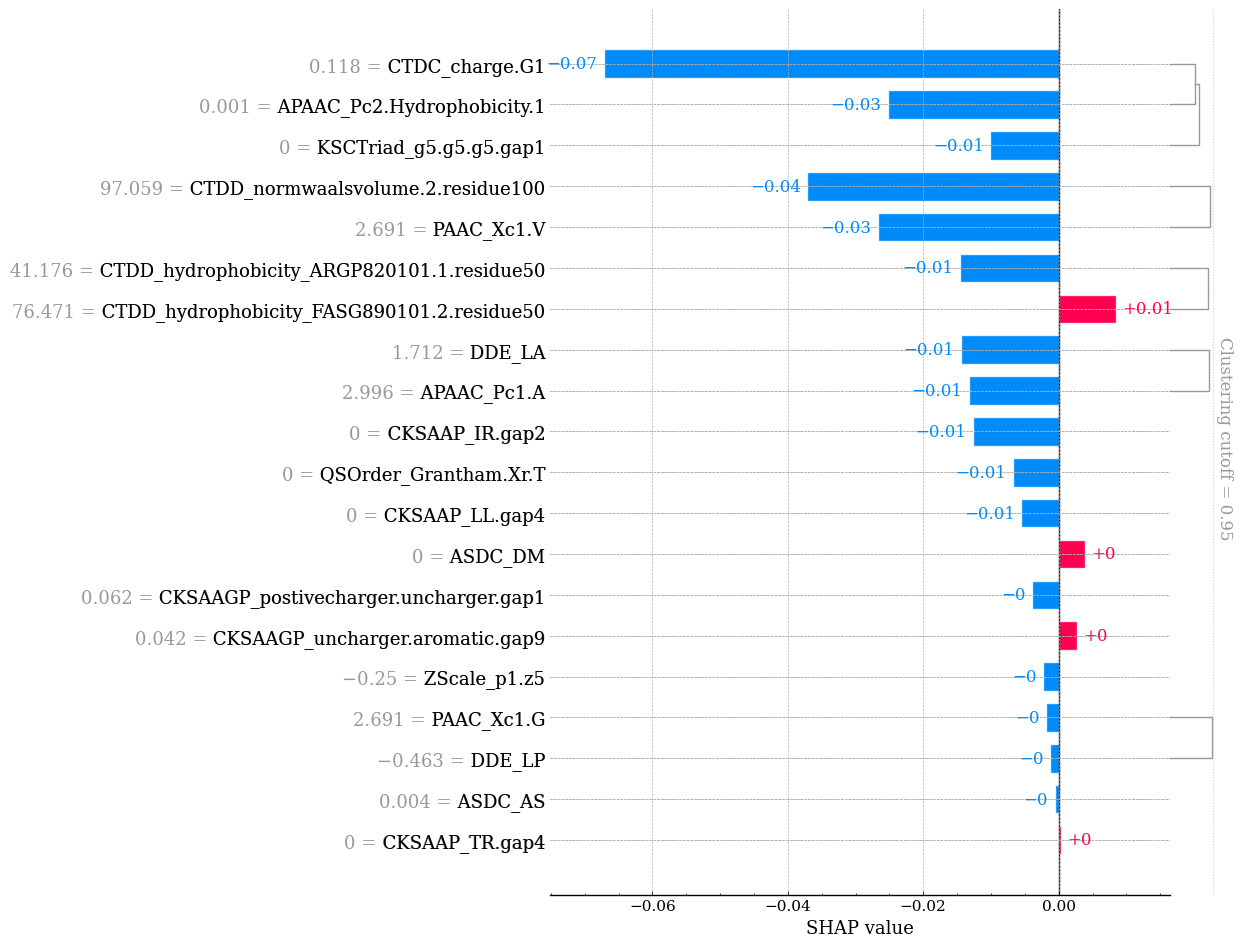

Optimized sequence: ELATKIFKRARKFRYRIWVRPCVVYGGAPIGNRM


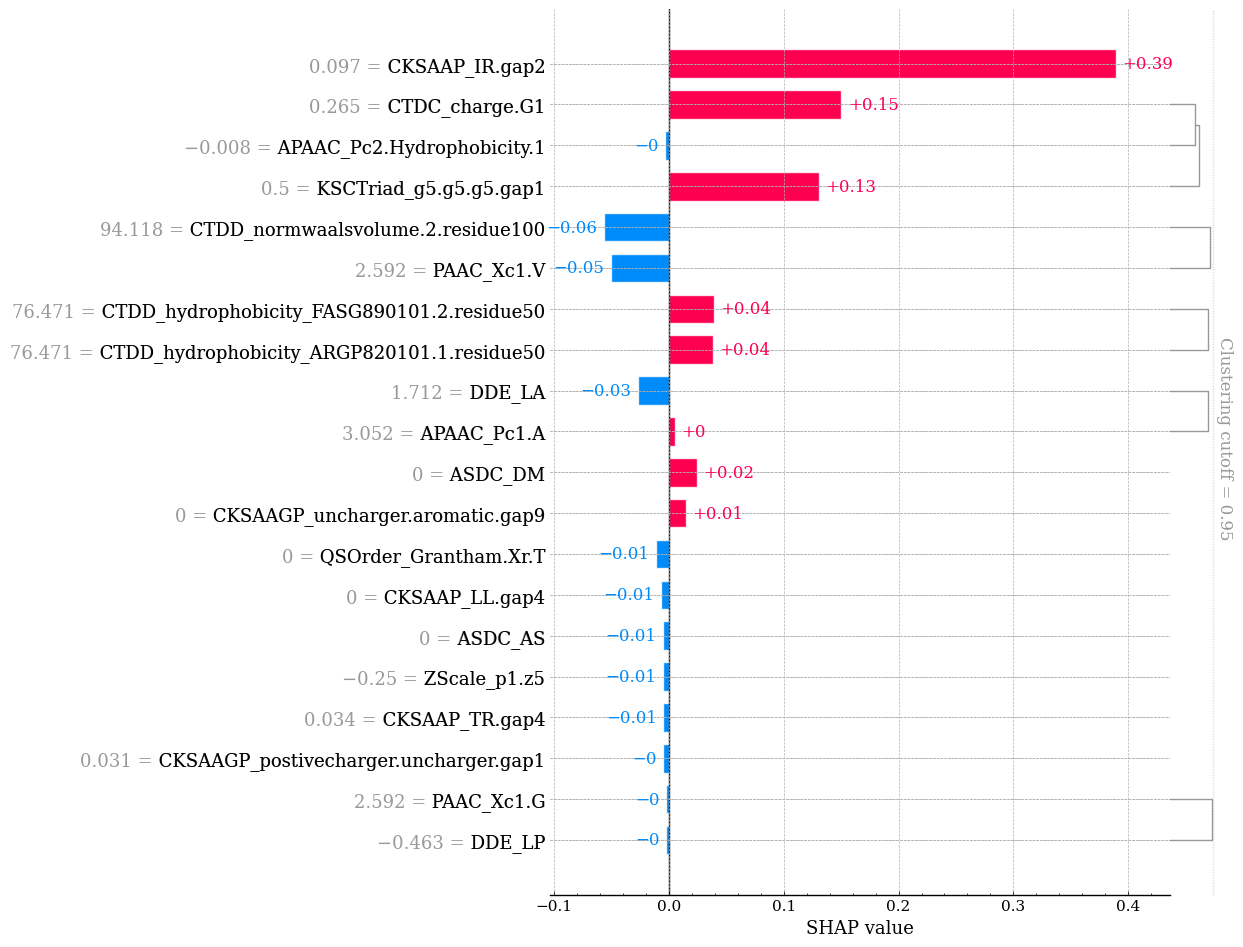

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Original sequence: ALAIIEESKQSGTPVSVGLLGNAADVY


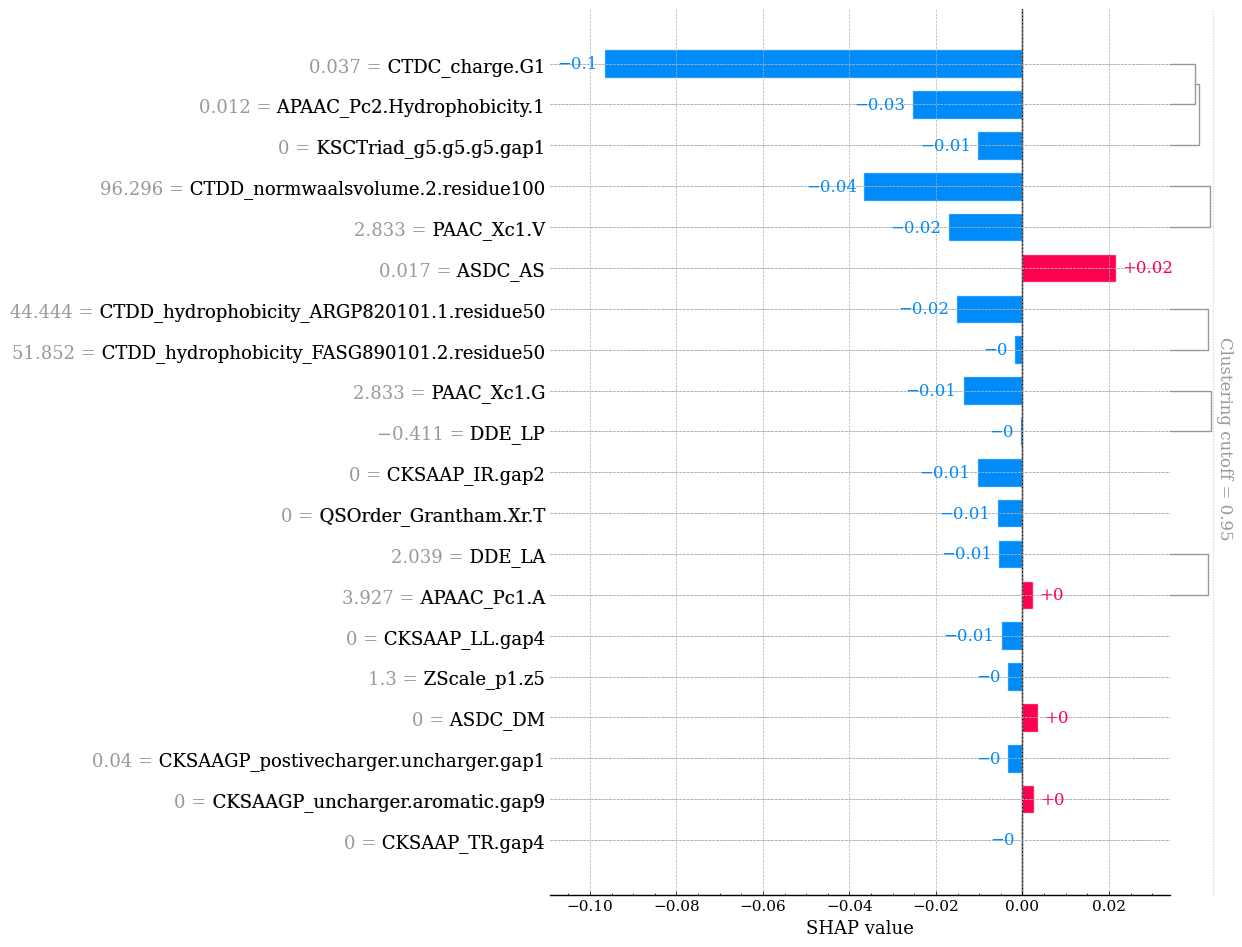

Optimized sequence: ALAIIEESKLKGRPLAIGLLGNAADAY


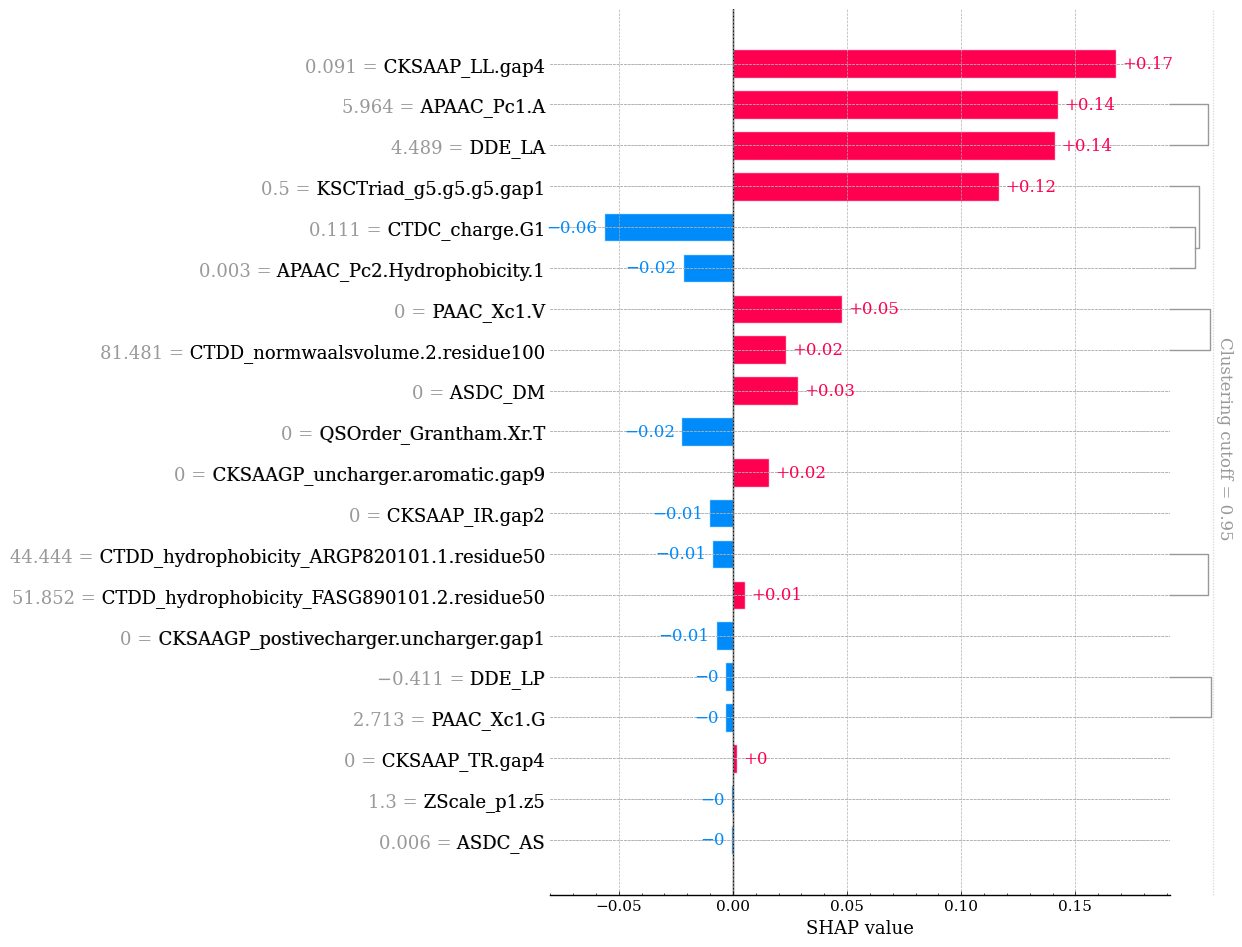

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [51]:
original_idxs = test_optimized[test_optimized['Dataset'] == 'Original_nonCPP'].index.values
optimized_idxs = test_optimized[test_optimized['Dataset'] == 'Optimized_CPP'].index.values

for original_idx, optimized_idx in zip(original_idxs, optimized_idxs):
    ### Original sequence
    print(f"Original sequence: {test_optimized.iloc[original_idx]['Sequence']}")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shap.plots.bar(shap_values_test_optimized[original_idx], max_display=20, show=False, clustering_cutoff=0.95, show_data=True)
    plt.show()
    
    FIG_SIZE = (12,12)
    SAVE_FIG = True
    FIG_FMT = 'pdf'
    TRANSPARENT_PNG=True
    save_fig(
        fig,
        f"original_{test_optimized.iloc[original_idx]['Sequence']}",
        fig_dir=os.path.join('..','figures'),
        fig_fmt=FIG_FMT,
        save=SAVE_FIG, 
        fig_size=FIG_SIZE,
        transparent_png=TRANSPARENT_PNG,
    )
    
    ### Optimized sequence
    print(f"Optimized sequence: {test_optimized.iloc[optimized_idx]['Sequence']}")
    ig = plt.figure()
    ax = fig.add_subplot(111)
    shap.plots.bar(shap_values_test_optimized[optimized_idx], max_display=20, show=False, clustering_cutoff=0.95, show_data=True)
    plt.show()
    
    FIG_SIZE = (12,12)
    SAVE_FIG = True
    FIG_FMT = 'pdf'
    TRANSPARENT_PNG=True
    save_fig(
        fig,
        f"optimized_{test_optimized.iloc[original_idx]['Sequence']}",
        fig_dir=os.path.join('..','figures'),
        fig_fmt=FIG_FMT,
        save=SAVE_FIG, 
        fig_size=FIG_SIZE,
        transparent_png=TRANSPARENT_PNG,
    )
    
    print('-'*200)